In [1]:
import sys
#sys.path.append('./conclude/newmethod/simulation_final/')
import os
#os.chdir('./conclude/newmethod/simulation_final/')
sys.path.append('/data/users/cs20s037/CITNonLinear/scripts')
sys.path.append('/data/users/cs20s037/CITNonLinear/')

In [2]:
import matplotlib.pyplot as plt
from scipy.special import logit
import seaborn as sns
import numpy as np
import math
from matplotlib.lines import Line2D
from scipy.stats import norm
from matplotlib.patches import Patch
import pandas as pd
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)
from sklearn.metrics import precision_score,recall_score
from sklearn import metrics 
import seaborn as sns
import os 
import matplotlib.patches as mpatches
from nlcd_user import *
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib.colors import ListedColormap
color_algo={'SVR':(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),'ANN':(0.21568627450980393, 0.4941176470588236, 0.7215686274509804),'CIT':(0.3019607843137256, 0.6862745098039216, 0.29019607843137263),'KRR':(0.5960784313725492, 0.3058823529411765, 0.6392156862745098),'findr':(1.0, 0.4980392156862745, 0.0),'mrpc':(0.9999999999999998, 1.0, 0.19999999999999996)}

In [3]:
# MRPC precision recall
def calculate_precision_recall_MRPC(causal,ind,causal_id=None,indep_id=None):
    precision_list=[]
    recall_list=[]
    pos=pd.read_csv(causal)

    neg=pd.read_csv(ind)

    for fdr in [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]: # 0 not included
    
        pos_cutoff= pos[pos['fdr'] == fdr ]
        if causal_id :
            pos_cutoff=pos_cutoff.iloc[causal_id,]
        neg_cutoff= neg[neg['fdr'] == fdr]
        if indep_id :
            neg_cutoff=neg_cutoff.iloc[indep_id,]
        
        
        #if yeast==False:

            #print(pos_cutoff)
    # Get column names starting with 'edge names'
        edge_columns = [col for col in pos_cutoff.columns if col.startswith('edge names')]
        TP = 0

        # Iterate through each row
        for index, row in pos_cutoff.iterrows():
            # Iterate through each edge column in the row
            for col in edge_columns:
                # Check if 'A|B' is present in the current edge column
                if 'A|B' == row[col]:
                    TP += 1
                    # Break the inner loop once 'A|B' is found in the current row
                    break
        FN=len(pos_cutoff)-TP


        FP= 0 
        edge_columns = [col for col in neg_cutoff.columns if col.startswith('edge names')]
        # Iterate through each row
        for index, row in neg_cutoff.iterrows():
            # Iterate through each edge column in the row
            for col in edge_columns:
                # Check if 'A|B' is present in the current edge column
                if 'A|B' == row[col]:
                    FP += 1
                    # Break the inner loop once 'A|B' is found in the current row
                    break
        TN=len(neg_cutoff)-FP

        precision=TP/(TP+FP)
        recall=TP/(TP+FN)

        precision_list.append(precision)
        recall_list.append(recall)

    precision_list.insert(0,precision_list[0])
    recall_list.insert(0,0)
    # extending to the right 
    if 1 not in recall_list:
        #0.5 because our random classifier number of false positives
        precision_list.append(0.5)
        recall_list.append(1)

    assert 1 in recall_list, "1 is not present in the recall list"
    return list(reversed(precision_list)),list(reversed(recall_list))


In [ ]:
# average precision function for MRPC
def calculate_avgprecision_MRPC(causal,ind,causal_id=None,indep_id=None):
    precision,recall=calculate_precision_recall_MRPC(causal,ind,causal_id,indep_id)
    average_precision_score = 0
    for i in range(0, len(precision)-1):
        precision_n = precision[i]
        recall_n = recall[i]
        recall_n_minus_1 = recall[i+1]
        increment = (recall_n - recall_n_minus_1) * precision_n
        average_precision_score += increment

    return average_precision_score



In [5]:
# function to calculate the precision recall for nlcd/cit
def calculate_precision_recall(causal,ind,causal_id=None,indep_id=None):
    #print("using new function, python inbuilt")
    precision=[]
    recall=[]
    presultscausal=pd.read_csv(causal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    presultscausal=presultscausal.iloc[:,:-2]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    presultsind=presultsind.iloc[:,:-2]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_cit' in pMix.columns:
        pMix.rename(columns={'p_cit':'p_final'}, inplace=True)
    gt=pMix['GroundTruth']
    pred=pMix['p_final']
    mask = ~np.isnan(pred)
    gt=gt[mask]
    pred=pred[mask]
    pred=1-pred  # taking 1 minus , because in our case lesser the p-value, the better. but in the curve function higher the better
    #the function returns decreasing recall values so find the first precision and extend it 
    precision,recall,thresholds=precision_recall_curve(gt,pred,pos_label=1)
    precision[-1]=precision[-2]
    assert 1 in recall, "1 is not present in the recall list"
    return precision,recall

        

In [ ]:
# function to calculate the precision recall for findr 
def calculate_precision_recall_findr(causal,ind,causal_id=None,indep_id=None):
    #print("using new function, python inbuilt")
    precision=[]
    recall=[]
    presultscausal=pd.read_csv(causal)
    #print(presultscausal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    #we need all the columns so commenting it out to delselect the last column 
    #presultscausal=presultscausal.iloc[:,:-1]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    #we need all the columns so commenting it out to delselect the last column 
    #presultsind=presultsind.iloc[:,:-1]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_val' in pMix.columns:
        pMix.rename(columns={'p_val':'p_final'}, inplace=True)
    gt=pMix['GroundTruth']
    pred=pMix['p_final']
    mask = ~np.isnan(pred)
    gt=gt[mask]
    pred=pred[mask]
    precision,recall,thresholds=precision_recall_curve(gt,pred,pos_label=1)
    precision[-1]=precision[-2]
    assert 1 in recall, "1 is not present in the recall list"
    return precision,recall
            

In [7]:
def read_data(data):

    #read the input file 
    fo=open(data, "r")
    L=[]
    A=[]
    B=[]
# the simulated data is generated with a seed at the start of the file
# so we skip it, but not for the yeast data 
# if yeast is present then dont read the seed line
    if(data.find('yeast')==-1 and data.find('human')==-1): #if yeast is not present
        line=fo.readline() # read the line, the control will start from the next line 

    while(1):
    # the first line of the trio is the parameter configuration, skip it 
        line=fo.readline()
    # read the genotype information 
        line=fo.readline()
        if line== "" :
            break
        l = [j for j in line.split()]
        L.append(np.array([int(i) for i in l]))
        line=fo.readline()
        a = [j for j in line.split()]
        A.append(np.array([float(i) for i in a]))
        line=fo.readline()
        b = [j for j in line.split()]
        B.append(np.array([float(i) for i in b]))
#combine all the samples into a list 
    dataset = [i for i in zip(L,A,B)]
    fo.close()
    return dataset

In [8]:
# function for average precision score
def calculate_avgprecision(causal,ind,causal_id=None,indep_id=None):
    presultscausal=pd.read_csv(causal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    presultscausal=presultscausal.iloc[:,:-2]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    presultsind=presultsind.iloc[:,:-2]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_cit' in pMix.columns:
        pMix.rename(columns={'p_cit':'p_final'}, inplace=True)
    gt=pMix['GroundTruth']
    pred=pMix['p_final']
    mask = ~np.isnan(pred)
    gt=gt[mask]
    pred=pred[mask]
    pred=1-pred  # taking 1 minus , because in our case lesser the p-value, the better. but in the curve function higher the better
    #the function returns decreasing recall values so find the first precision and extend it 
    return average_precision_score(gt,pred,pos_label=1)


        

In [9]:
def davis_goadrich_interpolation(precision, recall, positive, num=100):
    """Interpolation of the precision-recall curve according to
    Davis and Goadrich [1]_.

    Davis and Goadrich propose an hyperbolic interpolation to define the
    precision-recall curve. Values on the precision-recall curve are interpolated such
    as in the equation of section 4. of [1]_.

    Parameters
    ----------
    precision : ndarray of shape (n_samples,)
        Precision values as returned by :func:`~sklearn.metrics.precision_recall_curve`.

    recall : ndarray of shape (n_samples,)
        Recall values as returned by :func:`~sklearn.metrics.precision_recall_curve`.

    positive : int
        The total number of positive samples in the dataset used when calling
        :func:`~sklearn.metrics.precision_recall_curve`.

    num : int, default=100
        Number of points to interpolate between sub-integral true positive values.

    References
    ----------
    [1] Davis, Jesse, and Mark Goadrich.
        "The relationship between Precision-Recall and ROC curves."
        Proceedings of the 23rd international conference on Machine learning.
        2006.
    """
    # Remove the last value of precision and recall as it corresponds to the
    # point (0, 1) and will lead to a division by zero during interpolation
    # We add this value back later.
    precision=np.array(precision)
    recall=np.array(recall)
    precision_last,recall_last=precision[-1],recall[-1]
    precision, recall = precision[:-1], recall[:-1]
    # Invert also the order to have an increasing number of true positive later on
    precision, recall = precision[::-1], recall[::-1]
    true_positive = (recall * positive).round()
    false_positive = ((recall * positive) * (1 - precision) / precision).round()

    indices = np.arange(len(true_positive))

    def recall_interpolation(true_positive_start, true_positive_stop, positive, num):
        return np.linspace(true_positive_start, true_positive_stop, num=num) / positive

    def precision_interpolation(
        true_positive_start,
        true_positive_stop,
        false_positive_start,
        false_positive_stop,
        num,
    ):
        x = np.linspace(true_positive_start, true_positive_stop, num=num)
        increment_denominator = (
            (false_positive_stop - false_positive_start)
            / (true_positive_stop - true_positive_start)
            * (x - true_positive_start)
        )
        return x / (x + false_positive_start + increment_denominator)

    # We use a double list to concatenate all the element afterwards
    # Add back the PR point corresponding to the point (0, 1) 
    # In our case the point (0,1) need not be 1, it moved to the left, so instead of 1, it is of some value. 
    recall_interp, precision_interp = [[recall_last]], [[precision_last]]
    for indices_start, indices_stop in zip(indices[:-1], indices[1:]):
        # Interpolate sub-integral values
        true_positive_start = true_positive[indices_start]
        true_positive_stop = true_positive[indices_stop]
        false_positive_start = false_positive[indices_start]
        false_positive_stop = false_positive[indices_stop]
        if np.isclose(true_positive_start, true_positive_stop):
            # Discontinuity in the PR curve where true positive is constant
            # and false positive is increasing
            continue

        recall_interp.append(
            recall_interpolation(
                true_positive_start,
                true_positive_stop,
                positive,
                num,
            )
        )
        precision_interp.append(
            precision_interpolation(
                true_positive_start,
                true_positive_stop,
                false_positive_start,
                false_positive_stop,
                num,
            )
        )

    # Revert the order to be consistent with the output of precision_recall_curve
    return np.hstack(precision_interp)[::-1], np.hstack(recall_interp)[::-1]

In [10]:
# function for average precision score for findr
def calculate_avgprecision_findr(causal,ind,causal_id=None,indep_id=None):
    presultscausal=pd.read_csv(causal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    #presultscausal=presultscausal.iloc[:,:-2]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    #presultsind=presultsind.iloc[:,:-2]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_val' in pMix.columns:
        pMix.rename(columns={'p_val':'p_final'}, inplace=True)
    gt=pMix['GroundTruth']
    pred=pMix['p_final']
    mask = ~np.isnan(pred)
    gt=gt[mask]
    pred=pred[mask]
    #pred=1-pred  # findr, no 1-minus
    #the function returns decreasing recall values so find the first precision and extend it 
    return average_precision_score(gt,pred,pos_label=1)


        

In [11]:
# function to calculate the overlap endpoints in the plots
def overlap_endpoints_quadratic(*args): #       L,A,p, mu_0,mu_1,var_0,var_1,a):
    # parameter definition ##
    # a is the fraction of L values where L==0 
    # mu_0 is the mean of points of A(L==0)
    # mu_1 is the mean of points of A(L==1)
    # var_0 is the mean of points of A(L==0)
    # var_1 is the mean of points of A(L==1)     
    #############################
    ### this is calculating the parameters over the data 
    # Calculate mu_1: mean of A where L == 1
    if len(args)==3:
        A=args[1]
        L=args[0]
        p=args[2]
        mu_1 = A[L == 1].mean()
        mu_0 = A[L == 0].mean()
        var_1 = A[L == 1].var()
        var_0=A[L == 0].var()
        a = (L == 0).mean()

    ### this is by using the actual parameters 
    if len(args)==6:
        mu_0=args[1]
        mu_1=args[2]
        var_0=args[3]
        var_1=args[4]
        a=args[5]
        p=args[0]



    r= (1/(2*var_0)) -(1/(2*var_1)) 
    q= (mu_1/var_1) - (mu_0/var_0)
    s=((mu_0**2)/(2*var_0))-((mu_1**2)/(2*var_1))-(math.log(var_1)/2)+(math.log(var_0)/2)+logit(a)-logit(p)
    print("value of r",r)
    if(r!=0):
        if ((q**2 - 4 * r * s)>=0):
            x1 = (-q + math.sqrt(q**2 - 4 * r * s)) / (2 * r)
            x2 = (-q - math.sqrt(q**2 - 4 * r * s)) / (2 * r)
        else:
            print("discriminant negative!!")
    else:
        x1=-s/q 
        x2=-s/q
    try:
        if x1 > 0 and x2 > 0 and r!=0:
            print("Both roots are positive.")
        elif x1 < 0 and x2 < 0:
            raise ValueError("Both roots are negative.")
    except ValueError as e:
        print(f"Error: {e}")
        return None


    
    return max(x1,x2),x1,x2

In [13]:
##going to find the configurations for the next cell plot 
print("Linear configuration")
print(read_configuration('./data/Linear500.txt').iloc[52,])
print("Sine configuration")
print(read_configuration('./data/Sine500.txt').iloc[54,])
print("Saw configuration")
print(read_configuration('./data/Saw500.txt').iloc[54,])

Linear configuration
0    2.5
1      1
Name: 52, dtype: object
Sine configuration
0    2.5
1    0.6
2    0.5
3       
Name: 54, dtype: object
Saw configuration
0    2.5
1    0.6
2    0.5
3       
Name: 54, dtype: object


In [12]:
def fig2_a():
    ####### figure 2 a overlap depiction ############

    dflinear=read_data("./data/Linear500.txt") # going to read the data with the 52nd index 
    dfsine=read_data("./data/Sine500.txt") # going to read the data with the 54th index
    dfsaw=read_data("./data/Saw500.txt") # going to read the data with the 54th index 
    norows = 3
    nocols = 1

    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharey=True, figsize=(4, 10))
    #fig.suptitle('Example plots for different datatypes')

    curr_ax = ax[0]
    plot_index = 0
    curr_ax.scatter(dflinear[52][1], dflinear[52][2], c=dflinear[52][0], cmap='viridis', alpha=0.6)
    # end points calculation for linear
    print("Linear endpoints")
    beta1=2.5
    mu_0=0
    mu_1=2.5  ## beta1+ epsilon mean
    var_0=1
    var_1=1
    a=0.5
    print("Using the general formula true values")
    x_min,x1,x2=overlap_endpoints_quadratic(0.8,mu_0,mu_1,var_0,var_1,a)
    print("x min x1 x2",x_min,x1,x2)
    x_max,x1,x2=overlap_endpoints_quadratic(0.2,mu_0,mu_1,var_0,var_1,a)
    
    print("x max x1 x2",x_max,x1,x2)   

    #curr_ax.axvspan(xmin=0, xmax=2, alpha=0.3, color='gray') 
    curr_ax.axvspan(xmin=x_min, xmax=x_max, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')

    curr_ax.set_title('Linear')
    # Create custom legend handles with correct colors
    unique_labels = set(dfsaw[54][0])
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('viridis', num_labels)(range(num_labels))
    cmap = ListedColormap(colors)
    legend_handles = [mpatches.Patch(color=color, label=f'L={label}') for color, label in zip(colors, unique_labels)]

    # Create legend handles and labels for the shaded area
    shade_handle = mpatches.Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Shaded Area')

    # Combine legend handles and labels
    handles = legend_handles + [shade_handle]
    labels = ['L=0', 'L=1', 'Overlap']

    # Add the combined legend to the subplot
    curr_ax.legend(handles, labels, loc='lower right')

    curr_ax = ax[1]
    plot_index += 1
    beta1=2.5
    mu_0=0
    mu_1=2.5
    var_0=1
    var_1=1
    a=0.5
    curr_ax.scatter(dfsine[54][1], dfsine[54][2], c=dfsine[54][0], cmap='viridis', alpha=0.6)
    print("Sine endpoints")
    print("Using the general formula true values")
    x_min,x1,x2=overlap_endpoints_quadratic(0.8,mu_0,mu_1,var_0,var_1,a)
    print("x min x1 x2",x_min,x1,x2)
    x_max,x1,x2=overlap_endpoints_quadratic(0.2,mu_0,mu_1,var_0,var_1,a)
    print("x max x1 x2",x_max,x1,x2)   
    #curr_ax.axvspan(xmin=0, xmax=2, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.axvspan(xmin=x_min,xmax=x_max, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')
    curr_ax.set_title('Sine')

    curr_ax = ax[2]
    plot_index += 1
    curr_ax.scatter(dfsaw[54][1], dfsaw[54][2], c=dfsaw[54][0], cmap='viridis', alpha=0.6)
    beta1=2.5
    mu_0=0
    mu_1=2.5
    var_0=1
    var_1=1
    a=0.5
    print("Saw endpoints")
    print("Using the general formula true values")
    x_min,x1,x2=overlap_endpoints_quadratic(0.8,mu_0,mu_1,var_0,var_1,a)
    print("x min x1 x2",x_min,x1,x2)
    x_max,x1,x2=overlap_endpoints_quadratic(0.2,mu_0,mu_1,var_0,var_1,a)
    print("x max x1 x2",x_max,x1,x2)      
    #curr_ax.axvspan(xmin=0.3, xmax=2, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.axvspan(xmin=x_min, xmax=x_max, alpha=0.3, color='gray') 
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')
    curr_ax.set_title('Saw')



    plt.tight_layout()
    #plt.savefig("./results/journal/plots/fig2_example.png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/fig2_example.svg', bbox_inches='tight', format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/fig2_example.pdf', bbox_inches='tight', format='pdf', dpi=1200)

Linear endpoints
Using the general formula true values
value of r 0.0
x min x1 x2 1.8045177444479563 1.8045177444479563 1.8045177444479563
value of r 0.0
x max x1 x2 0.6954822555520438 0.6954822555520438 0.6954822555520438
Sine endpoints
Using the general formula true values
value of r 0.0
x min x1 x2 1.8045177444479563 1.8045177444479563 1.8045177444479563
value of r 0.0
x max x1 x2 0.6954822555520438 0.6954822555520438 0.6954822555520438
Saw endpoints
Using the general formula true values
value of r 0.0
x min x1 x2 1.8045177444479563 1.8045177444479563 1.8045177444479563
value of r 0.0
x max x1 x2 0.6954822555520438 0.6954822555520438 0.6954822555520438


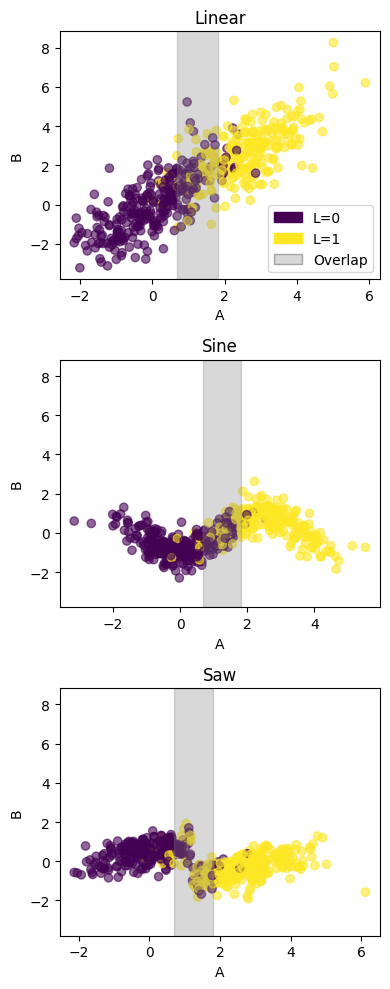

In [22]:
fig2_a()

In [27]:
def suppl_s1_b():
    ### Figure supplementary S1 b ################
    #nlcd_dir="./results/journal/simulation/nlcd/"
    #cit_dir="./results/journal/simulation/cit/"
    nlcd_dir="./results/simulation/nlcd/"
    cit_dir="./results/simulation/cit/"
    norows=3
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))

    plot_index = 0

    for i in ['300', '500', '1000'] :
        for j in ['Linear', 'Sine', 'Saw']:
            for k in [ '100']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")

                curr_ax = ax[plot_index // nocols, plot_index % nocols]
                
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                if(plot_index // nocols == 0 and plot_index % nocols == 0):
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Sine')
                elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index % nocols == 0 and plot_index//norows==0):
                    curr_ax.set_ylabel('Sample size =300 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==1):
                    curr_ax.set_ylabel('Sample size =500 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==2):
                    curr_ax.set_ylabel('Sample size =1000 \n Precision')
                if(plot_index //nocols == (norows-1)):
                    curr_ax.set_xlabel('Recall')
                if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[xindex, yindex].lines[3],ax[xindex,yindex].lines[0], ax[xindex, yindex].lines[1],ax[xindex, yindex].lines[2]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT (baseline)']
                    curr_ax.legend(handles,labels,loc="lower left")
            

                plot_index += 1

    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig_2_suppl_a.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_a.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_a.pdf', bbox_inches='tight',format='pdf', dpi=1200)


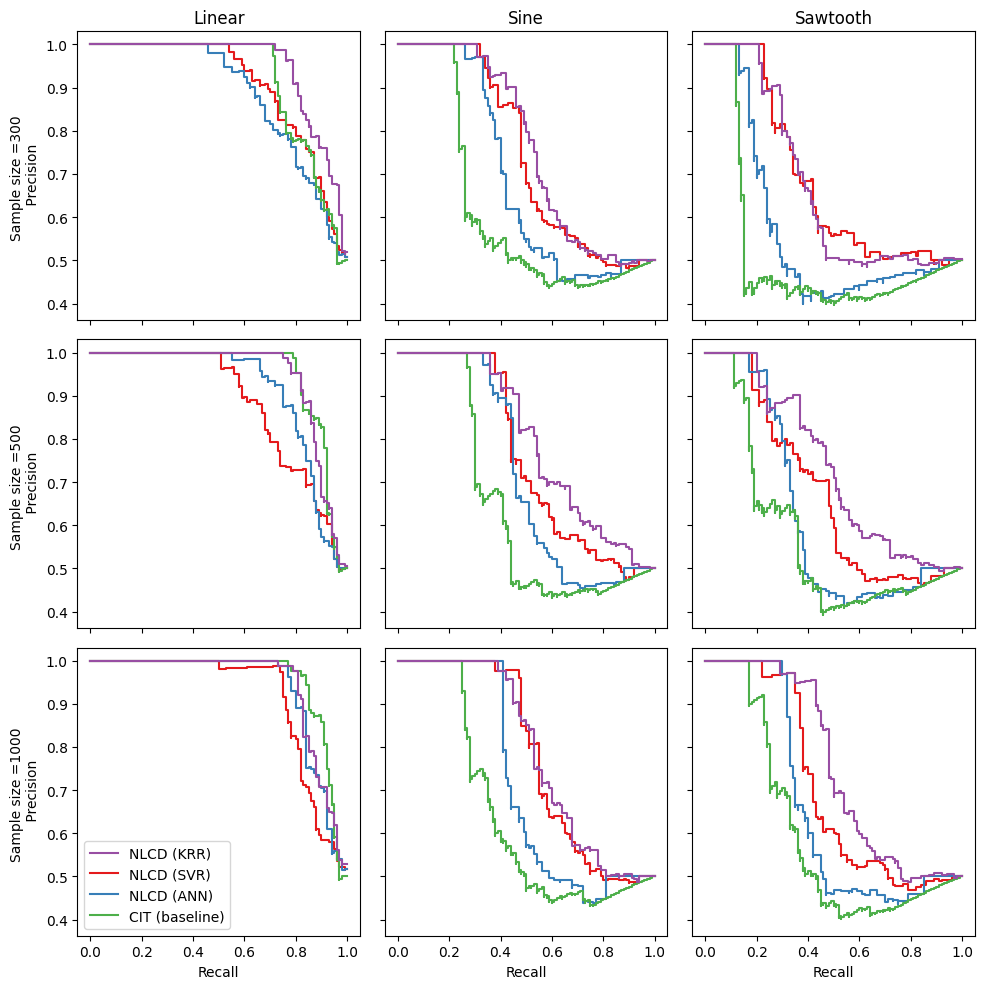

In [28]:
suppl_s1_b()

In [29]:
def suppl_s4():
    #### Figure supplementary S4 ###########
    #nlcd_dir='./results/journal/2way/'
    nlcd_dir='./results/2way/'
    norows = 2
    nocols = 2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8, 7))
    #fig.suptitle("Hex plot of p-values from A->B vs B->A p for NLCD(KRR) 100 permutations ")
    plot_index = 0

    for j in ['Linear', 'Sine', 'Saw', 'Indp']:
        dfcausal = pd.read_csv(nlcd_dir + j + 'KRR500s100perm.csv')
        dfrev = pd.read_csv(nlcd_dir + j + 'KRR500s100perm_rev.csv')
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        hb = curr_ax.hexbin(dfcausal['p_final'], dfrev['p_final'], gridsize=5, mincnt=1, cmap='Blues',vmin=0,vmax=30)
        
        if(plot_index == 0 or plot_index == 2):
            curr_ax.set_ylabel('B->A')
        else:
            curr_ax.set_ylabel('')
        curr_ax.set_xlabel('A->B ')
        
        if(j == 'Linear'):
            curr_ax.set_title('Linear')
        elif(j == 'Sine'):
            curr_ax.set_title('Sine')
        elif(j == 'Saw'):
            curr_ax.set_title('Sawtooth')
        elif(j == 'Indp'):
            curr_ax.set_title('Independent')
        
        plot_index += 1

    cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])  # Adjust the position and size of the colorbar as needed
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('Counts')


    #plt.savefig("./results/journal/plots/fig_2_suppl_b.png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_b.svg', bbox_inches='tight', format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_b.pdf', bbox_inches='tight', format='pdf', dpi=1200)

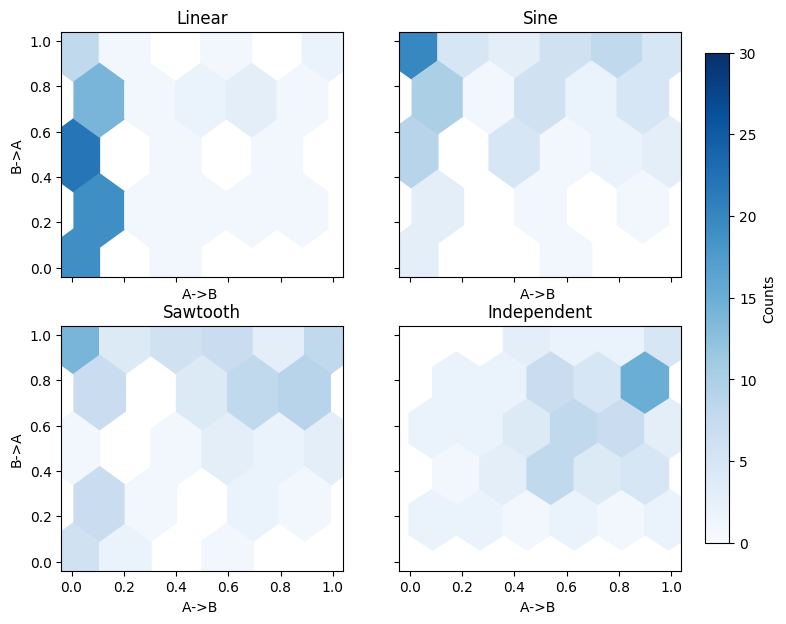

In [30]:
suppl_s4()

In [44]:
def suppl_s3():
    ########## Figure Supplementary S3 #######
    norows=1
    nocols=3
    nlcd_dir='./results/simulation/nlcd/'
    cit_dir='./results/simulation/cit/'
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(5,3))
    #fig.suptitle("Test 3 comparison of NLCD vs CIT p-values :\n 500 sample size , 500 permutations ")
    #cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar_ax = fig.add_axes([0.98, 0.15, 0.02, 0.7])
    x='p_AassocB|L'
    y='p_TG'
    count=0
    for j in ['Linear', 'Sine', 'Saw']: 
                    
        curr_ax = ax[count]
        count+=1
        curr_ax.set_ylabel('')
        curr_ax.set_xlabel('')
        dfnlcd=pd.read_csv(nlcd_dir+j+'KRR500s500perm.csv')
        dfcit=pd.read_csv(cit_dir+j+'500cit500perm.csv') 
        hb=curr_ax.hexbin(dfnlcd[x], dfcit[y], gridsize=5,mincnt=1, cmap='plasma',vmin=0,vmax=100)
        if(count==2 ):
            curr_ax.set_xlabel('NLCD A ~ B|L', labelpad=20)

        if(count==1):
            curr_ax.set_title('Linear')
        if(count==2):
            curr_ax.set_title('Sine')
        if(count==3):
            curr_ax.set_title('Sawtooth')   
        if(count==1):
            curr_ax.set_ylabel(' CIT A ~ B|L')
            
            

    cbar = fig.colorbar(hb, cax=cbar_ax)
    #cbar = fig.colorbar
    cbar.set_label('Counts')
    #plt.tight_layout()
    #plt.savefig("./results/journal/plots/fig_3_mod_main.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_3_mod_main.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('/data/users/cs20s037/CITNonLinear/conclude/newmethod/simulation_final/results/journal/plots/suppl_s3.pdf', bbox_inches='tight', format='pdf', dpi=1200)

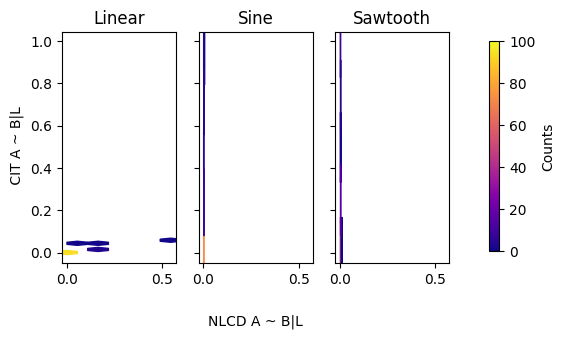

In [45]:
suppl_s3()

In [46]:
def suppl_s1_a():
    ### Figure Supplementary S1 a ################
    #this is for sample 500
    nlcd_dir="./results/simulation/nlcd/"
    cit_dir="./results/simulation/cit/"
    findr_dir="./results/simulation/findr/"
    mrpc_dir="./results/simulation/mrpc/sim_results/edges_robust/"
    norows=3
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    #fig.suptitle("Precision-Recall Curve plots for 500 permutations ")
    plot_index = 0

    for i in [ '300','500','1000'] :
        for j in ['Linear', 'Sine', 'Saw']:
            print("Data type: ", j)
            for k in [ '500']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                print('nlcd SVR ',calculate_avgprecision(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv"))
                
                precision_nlmr_SVR,recall_nlmr_SVR=davis_goadrich_interpolation(precision_nlmr_SVR,recall_nlmr_SVR,positive=100)
                
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                print('nlcd krr ',calculate_avgprecision(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv"))
                
                precision_nlmr_KRR,recall_nlmr_KRR=davis_goadrich_interpolation(precision_nlmr_KRR,recall_nlmr_KRR,positive=100)
                
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                print('nlcd ann ',calculate_avgprecision(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv"))
               
                precision_nlmr_ANN,recall_nlmr_ANN=davis_goadrich_interpolation(precision_nlmr_ANN,recall_nlmr_ANN,positive=100)
                
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                print('cit ',calculate_avgprecision(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv"))
                
                precision_CIT,recall_CIT=davis_goadrich_interpolation(precision_CIT,recall_CIT,positive=100)
                
                precision_findr, recall_findr = calculate_precision_recall_findr(findr_dir + j + i  +"findr"+ ".csv", findr_dir + "Indp" + i +"findr"  + ".csv")
                print('findr ',calculate_avgprecision_findr(findr_dir + j + i  +"findr"+ ".csv", findr_dir + "Indp" + i +"findr"  + ".csv"))
                
                precision_findr,recall_findr=davis_goadrich_interpolation(precision_findr,recall_findr,positive=100)
                
                precision_mrpc, recall_mrpc = calculate_precision_recall_MRPC(mrpc_dir + j + i  +"mrpc"+ ".csv", mrpc_dir + "Indp" + i +"mrpc"  + ".csv")
                print('mrpc ',calculate_avgprecision_MRPC(mrpc_dir + j + i  +"mrpc"+ ".csv", mrpc_dir + "Indp" + i +"mrpc"  + ".csv"))
        
                precision_mrpc,recall_mrpc=davis_goadrich_interpolation(precision_mrpc,recall_mrpc,positive=100)
                curr_ax = ax[plot_index // nocols, plot_index % nocols]
        
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
               
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_findr, recall=recall_findr)
                disp.plot(ax=curr_ax, color=color_algo['findr'])
                disp = PrecisionRecallDisplay(precision=precision_mrpc, recall=recall_mrpc)
                disp.plot(ax=curr_ax, color=color_algo['mrpc'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Sine')
                elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index % nocols == 0 and plot_index//norows==0):
                    curr_ax.set_ylabel('Sample size =300 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==1):
                    curr_ax.set_ylabel('Sample size =500 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==2):
                    curr_ax.set_ylabel('Sample size =1000 \n Precision')
                if(plot_index //nocols == (norows-1)):
                    curr_ax.set_xlabel('Recall')
                if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    xindex=norows-1
                    yindex=0
                    #handles = [ax[ yindex].lines[2],ax[yindex].lines[0], ax[ yindex].lines[1],ax[yindex].lines[3],ax[yindex].lines[4],ax[yindex].lines[5]]
                    handles = [ax[xindex, yindex].lines[2],ax[xindex,yindex].lines[0], ax[xindex, yindex].lines[1],ax[xindex, yindex].lines[3],ax[xindex,yindex].lines[4],ax[xindex,yindex].lines[5]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT','Findr','MRPC']
                    curr_ax.legend(handles,labels,loc="lower left")
                
                plot_index += 1
        


    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig2_suppl_a_mod.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig2_suppl_a_mod.svg', bbox_inches='tight',format='svg', dpi=1200)


Data type:  Linear
nlcd SVR  0.9068314852732967
nlcd krr  0.9444445952826288
nlcd ann  0.9025528824806026
cit  0.9172536407596429
findr  0.9302683219412918
mrpc  0.974382544783618
Data type:  Sine
nlcd SVR  0.7471726112627813
nlcd krr  0.7679818887029096
nlcd ann  0.6925986878950305
cit  0.6171387647206239
findr  0.5540151451794249
mrpc  0.7215106106999073
Data type:  Saw
nlcd SVR  0.6835584441898255
nlcd krr  0.6791830020744168
nlcd ann  0.5801910214149489
cit  0.5172962949958584
findr  0.47932092173648777
mrpc  0.6811866538618968
Data type:  Linear
nlcd SVR  0.8886367101396497
nlcd krr  0.9453262568891792
nlcd ann  0.9268913684595477
cit  0.9477805356485232
findr  0.939568311960316
mrpc  0.989095757126733
Data type:  Sine
nlcd SVR  0.7577441075878831
nlcd krr  0.8004133141934184
nlcd ann  0.7119272125099945
cit  0.6453593914691937
findr  0.6266150669564942
mrpc  0.7758470726709739
Data type:  Saw
nlcd SVR  0.671806580100555
nlcd krr  0.7325465385969445
nlcd ann  0.6390823096236726
ci

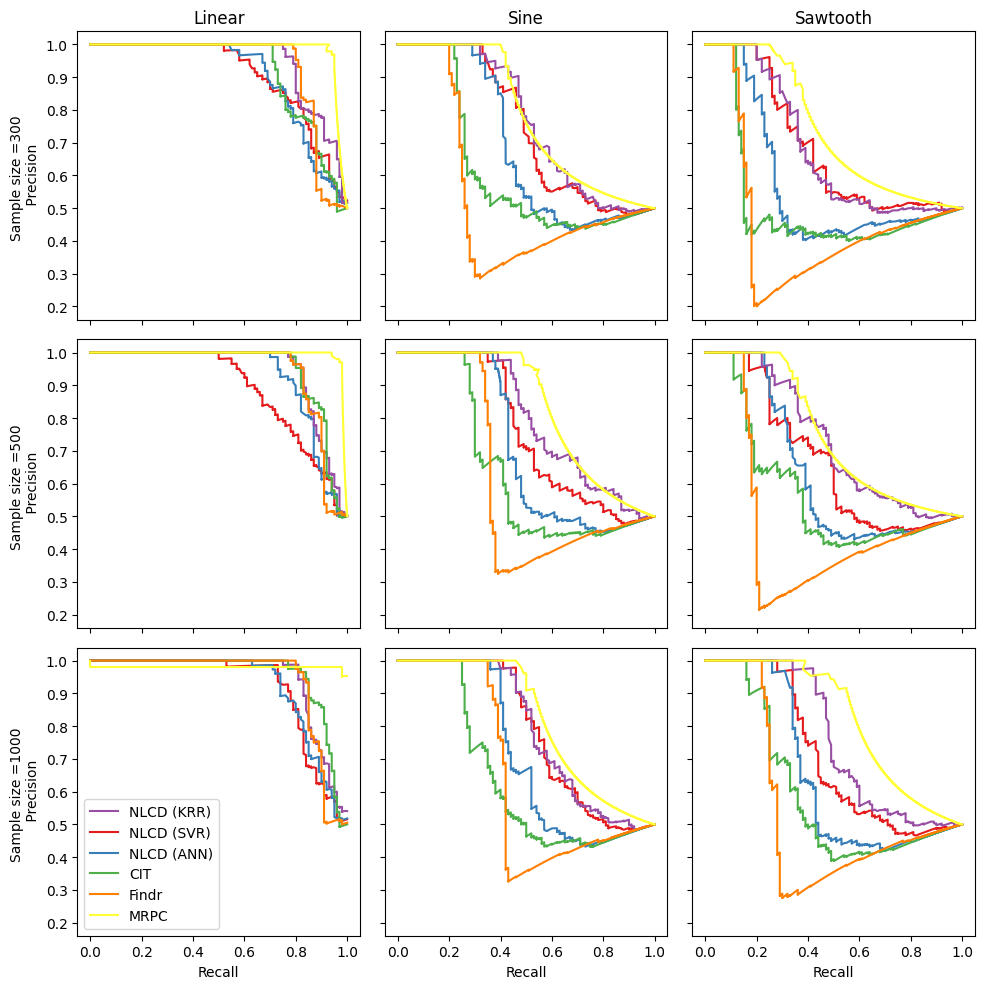

In [47]:

suppl_s1_a()

In [ ]:
def fig3():
    ### Figure 3 AUPR ################
    #this is for sample 500
    nlcd_dir="./results/simulation/nlcd/"
    cit_dir="./results/simulation/cit/"
    findr_dir="./results/simulation/findr/"
    mrpc_dir="./results/simulation/mrpc/sim_results/edges_robust/"
    norows=3
    nocols=1
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(4,10))
    #fig.suptitle("Precision-Recall Curve plots for 500 permutations ")
    plot_index = 0

    for i in [ '500'] :
        for j in ['Linear', 'Sine', 'Saw']:
            print("Data type: ", j)
            for k in [ '500']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                print('nlcd SVR ',calculate_avgprecision(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv"))
                nlcd_svr=calculate_avgprecision(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")

                precision_nlmr_SVR,recall_nlmr_SVR=davis_goadrich_interpolation(precision_nlmr_SVR,recall_nlmr_SVR,positive=100)
                
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                print('nlcd krr ',calculate_avgprecision(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv"))
                nlcd_krr=calculate_avgprecision(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
 
                precision_nlmr_KRR,recall_nlmr_KRR=davis_goadrich_interpolation(precision_nlmr_KRR,recall_nlmr_KRR,positive=100)
                
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                print('nlcd ann ',calculate_avgprecision(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv"))
                nlcd_ann=calculate_avgprecision(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                
                precision_nlmr_ANN,recall_nlmr_ANN=davis_goadrich_interpolation(precision_nlmr_ANN,recall_nlmr_ANN,positive=100)
                
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                print('cit ',calculate_avgprecision(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv"))
                cit=calculate_avgprecision(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                precision_CIT,recall_CIT=davis_goadrich_interpolation(precision_CIT,recall_CIT,positive=100)
                
                precision_findr, recall_findr = calculate_precision_recall_findr(findr_dir + j + i  +"findr"+ ".csv", findr_dir + "Indp" + i +"findr"  + ".csv")
                print('findr ',calculate_avgprecision_findr(findr_dir + j + i  +"findr"+ ".csv", findr_dir + "Indp" + i +"findr"  + ".csv"))
                findr=calculate_avgprecision_findr(findr_dir + j + i  +"findr"+ ".csv", findr_dir + "Indp" + i +"findr"  + ".csv")

                precision_findr,recall_findr=davis_goadrich_interpolation(precision_findr,recall_findr,positive=100)
                
                precision_mrpc, recall_mrpc = calculate_precision_recall_MRPC(mrpc_dir + j + i  +"mrpc"+ ".csv", mrpc_dir + "Indp" + i +"mrpc"  + ".csv")
                print('mrpc ',calculate_avgprecision_MRPC(mrpc_dir + j + i  +"mrpc"+ ".csv", mrpc_dir + "Indp" + i +"mrpc"  + ".csv"))
                mrpc =calculate_avgprecision_MRPC(mrpc_dir + j + i  +"mrpc"+ ".csv", mrpc_dir + "Indp" + i +"mrpc"  + ".csv")

                #precision_mrpc,recall_mrpc=davis_goadrich_interpolation(precision_mrpc,recall_mrpc,positive=100)
                curr_ax = ax[plot_index]
        
        
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index  == 0 ):        
                    curr_ax.set_title('Linear')
                elif(plot_index == 1 ):
                    curr_ax.set_title('Sine')
                elif(plot_index  == 2 ):
                    curr_ax.set_title('Sawtooth')   
                #if(plot_index ==2):
                    #curr_ax.set_ylabel('Sample size =500 \n Precision') 
                    #curr_ax.set_xlabel('Different Methods')
                curr_ax.set_ylabel('AUPRC') 
                curr_ax.set_ylim(0.4,1.1) 

                
                plot_index += 1


                algo_means = {
                'CIT': round(cit,2),
                'NLCD (KRR)': round(nlcd_krr,2),
                'NLCD (SVR)': round(nlcd_svr,2),
                'NLCD (ANN)': round(nlcd_ann,2),
                'Findr':round(findr,2),
                'MRPC':round(mrpc,2)
                }
                species=list(algo_means.keys())
                print(species)
                #x = np.arange(len(species))  # the label locations
                width = 0.5 # the width of the bars , change this if the numbers are overlapping 
                #x=0
                #multiplier = 0
                x = range(len(species))
            #ax=axs[l_index]
            for idx, (attribute, measurement) in enumerate(algo_means.items()):
                #offset = width * multiplier
                if attribute=='CIT':
                    rects = curr_ax.bar(x[idx] , measurement, width,label=attribute,color=color_algo['CIT'],capsize=4)
                    curr_ax.bar_label(rects, padding=5)
                elif attribute=='NLCD (SVR)':
                    rects = curr_ax.bar(x[idx] , measurement, width,label=attribute,color=color_algo['SVR'],capsize=4)    
                    curr_ax.bar_label(rects, padding=5)
                elif attribute=='NLCD (KRR)':
                    rects = curr_ax.bar(x[idx], measurement, width,label=attribute,color=color_algo['KRR'],capsize=4)    
                    curr_ax.bar_label(rects, padding=5)
                elif attribute=='NLCD (ANN)':
                    rects = curr_ax.bar(x[idx]  , measurement, width,label=attribute,color=color_algo['ANN'],capsize=4)    
                    curr_ax.bar_label(rects, padding=5)
                elif attribute=='Findr':
                    rects = curr_ax.bar(x[idx] , measurement, width, label=attribute,color=color_algo['findr'],capsize=4)    
                    curr_ax.bar_label(rects, padding=5) 
                elif attribute=='MRPC':
                    rects = curr_ax.bar(x[idx]  , measurement, width, label=attribute,color=color_algo['mrpc'],capsize=4)    
                    curr_ax.bar_label(rects, padding=5) 

               # multiplier += 1
            curr_ax.set_xticks(x)
            curr_ax.set_xticklabels(species,rotation=90)
    

    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig3_mod_main_aupr.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig3_mod_main_aupr.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig("fig3.pdf", format="pdf", bbox_inches="tight",dpi=1200)



Data type:  Linear
nlcd SVR  0.8886367101396497
nlcd krr  0.9453262568891792
nlcd ann  0.9268913684595477
cit  0.9477805356485232
findr  0.939568311960316
mrpc  0.989095757126733
['CIT', 'NLCD (KRR)', 'NLCD (SVR)', 'NLCD (ANN)', 'Findr', 'MRPC']
Data type:  Sine
nlcd SVR  0.7577441075878831
nlcd krr  0.8004133141934184
nlcd ann  0.7119272125099945
cit  0.6453593914691937
findr  0.6266150669564942
mrpc  0.7758470726709739
['CIT', 'NLCD (KRR)', 'NLCD (SVR)', 'NLCD (ANN)', 'Findr', 'MRPC']
Data type:  Saw
nlcd SVR  0.671806580100555
nlcd krr  0.7325465385969445
nlcd ann  0.6390823096236726
cit  0.5778070312383121
findr  0.49498924949324563
mrpc  0.6873432050066077
['CIT', 'NLCD (KRR)', 'NLCD (SVR)', 'NLCD (ANN)', 'Findr', 'MRPC']


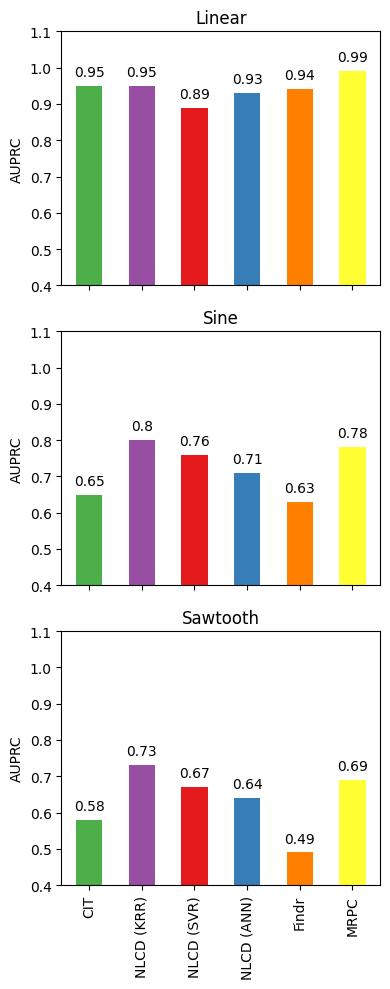

In [19]:
fig3()

In [50]:
def fig2_b():
    ### Figure 2 b ################
    #this is for sample 500
    nlcd_dir="./results/simulation/nlcd/"
    norows=3
    nocols=1
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(4,10))
    #fig.suptitle("Precision-Recall Curve plots for 500 permutations ")
    plot_index = 0

    for i in [ '500'] :
        for j in ['Linear', 'Sine', 'Saw']:
            print("Data type: ", j)
            for k in [ '500']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                print('nlcd SVR ',calculate_avgprecision(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv"))

                precision_nlmr_SVR,recall_nlmr_SVR=davis_goadrich_interpolation(precision_nlmr_SVR,recall_nlmr_SVR,positive=100)
                
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                print('nlcd krr ',calculate_avgprecision(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv"))

                precision_nlmr_KRR,recall_nlmr_KRR=davis_goadrich_interpolation(precision_nlmr_KRR,recall_nlmr_KRR,positive=100)
                
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                print('nlcd ann ',calculate_avgprecision(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv"))

                precision_nlmr_ANN,recall_nlmr_ANN=davis_goadrich_interpolation(precision_nlmr_ANN,recall_nlmr_ANN,positive=100)
                curr_ax = ax[plot_index]
                
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
               
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])

                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index  == 0 ):        
                    curr_ax.set_title('Linear')
                elif(plot_index == 1 ):
                    curr_ax.set_title('Sine')
                elif(plot_index  == 2 ):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index ==2):
                    #curr_ax.set_ylabel('Sample size =500 \n Precision') 
                    curr_ax.set_xlabel('Recall')
                curr_ax.set_ylabel('Precision') 
                
                if(plot_index==0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[ yindex].lines[2],ax[yindex].lines[0], ax[ yindex].lines[1]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)']
                    curr_ax.legend(handles,labels,loc="lower left")

                
                plot_index += 1

    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig2_mod_main_nlcd.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig2_mod_main_nlcd.svg', bbox_inches='tight',format='svg', dpi=1200)


Data type:  Linear
nlcd SVR  0.8886367101396497
nlcd krr  0.9453262568891792
nlcd ann  0.9268913684595477
Data type:  Sine
nlcd SVR  0.7577441075878831
nlcd krr  0.8004133141934184
nlcd ann  0.7119272125099945
Data type:  Saw
nlcd SVR  0.671806580100555
nlcd krr  0.7325465385969445
nlcd ann  0.6390823096236726


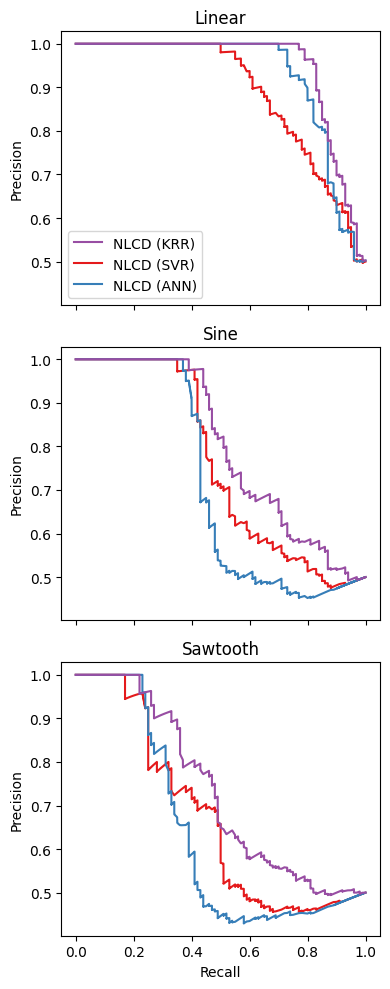

In [51]:
fig2_b()

In [52]:
def suppl_s2_a():
    ### Supplementary figure S2 a################
    nlcd_dir="./results/10run/runvariation/nlcd/"
    cit_dir="./results/10run/runvariation/cit/"
    norows=2
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8,5))
    fig.suptitle("PR curves for 10 runs ")

    plot_index = 0

    for k in [ '100','500']: 
        for j in ['Linear','Sine','Saw']:
            for i in ['1','2','3','4','5','6','7','8','9','10']:
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir+j+"KRR500s" + k +"perm"+i+"run"+".csv", nlcd_dir+"IndpKRR500s" + k + "perm"+i+"run"+".csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir+j+"500cit" + k + "perm"+"run"+i+".csv", cit_dir+"Indp500cit" + k + "perm"+"run"+i+".csv")

                curr_ax = ax[ plot_index//nocols,plot_index % nocols]

                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])  
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title("Linear")
                curr_ax.set_ylabel("Permutations=100 \n Precision ")
            if(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title("Sine")
            if(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title("Sawtooth")
            if(plot_index // nocols == 1 ):
                if(plot_index % nocols == 0):
                    curr_ax.set_ylabel("Permutations=500 \n Precision")
                curr_ax.set_xlabel("Recall")
                
            if(plot_index // nocols == 1 and plot_index % nocols == 0) :
                xindex=norows-1
                yindex=0
                handles = [curr_ax.lines[0],curr_ax.lines[1]]
                labels = ['NLCD (KRR)','CIT (baseline)']
                curr_ax.legend(handles,labels,loc="lower left")
            
            plot_index += 1
        


    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig_2_suppl_c.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_c.svg', bbox_inches='tight',format='svg', dpi=1200)


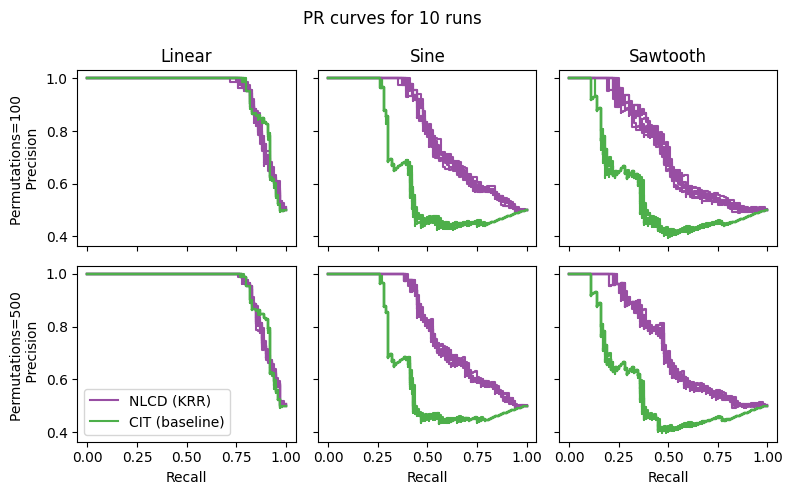

In [53]:
suppl_s2_a()

In [56]:
def suppl_s2_b():
    ### Supplementary Figure S2 b ################
    nlcd_dir="./results/10run/datavariation/nlcd/"
    cit_dir="./results/10run/datavariation/cit/"
    norows=2
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8,5))
    fig.suptitle("PR curves for 10 different datasets ")

    plot_index = 0

    for k in [ '100','500']: 
        for j in ['Linear','Sine','Saw']:
            for i in ['1','2','3','4','5','6','7','8','9','10']:
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir+j+"KRR500s" + k +"perm"+i+"run"+".csv", nlcd_dir+"IndpKRR500s" + k + "perm"+i+"run"+".csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir+j+"500cit" + k + "perm"+"run"+i+".csv", cit_dir+"Indp500cit" + k + "perm"+"run"+i+".csv")

                curr_ax = ax[ plot_index//nocols,plot_index % nocols]

                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])    
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title("Linear")
                curr_ax.set_ylabel("Permutations=100 \n Precision")
            if(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title("Sine")
            if(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title("Sawtooth")
            if(plot_index // nocols == 1 ):
                if(plot_index % nocols == 0):
                    curr_ax.set_ylabel("Permutations=500 \n Precision")
                curr_ax.set_xlabel("Recall")
                
            if(plot_index // nocols == 1 and plot_index % nocols == 0) :
                xindex=norows-1
                yindex=0
                handles = [curr_ax.lines[0],curr_ax.lines[1]]
                labels = ['NLCD (KRR)','CIT (baseline)']
                curr_ax.legend(handles,labels,loc="lower left")
            
            plot_index += 1
        


    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig_2_suppl_d.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_d.svg', bbox_inches='tight',format='svg', dpi=1200)


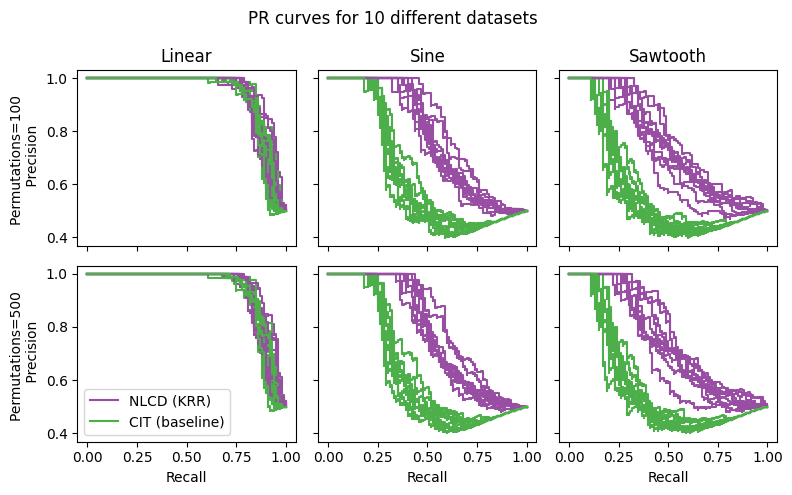

In [57]:
suppl_s2_b()

In [ ]:
def suppl_s5_a():
    ### Supplementary Figure S5 a #################### 
    #sample size of 500 and 100 permutations
    nlcd_dir="./results/simulation/nlcd/"
    cit_dir="./results/simulation/cit/"
    norows=1
    nocols=4
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(9,3))

    color_purple  = sns.color_palette("Purples", 3)
    color_green = sns.color_palette("Greens", 3)

    fig.text(0.21,0.99, 'Unequal variance', va='center', rotation='horizontal',fontsize=13)
    fig.text(0.71,0.99, 'Equal variance', va='center', rotation='horizontal',fontsize=13)
    plot_index = 0

    for j in ['Linearvar', 'Paravar','Linear','Para']:
        col_indx=0
        #curr_ax = ax[plot_index // nocols, plot_index % nocols]
        curr_ax=ax[plot_index]
        #for i in ['300', '500', '1000'] :
        for i in ['500']:
            for k in [ '100']: 
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                print("Datatype",j,"Sample",i,"Permutations",k)
                print("AUC CIT",auc(recall_CIT, precision_CIT))
                print("AUC NLMR",auc(recall_nlmr_KRR, precision_nlmr_KRR))
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index ==0 or plot_index==2):        
                    curr_ax.set_title('Linear')
                elif(plot_index==1 or plot_index==3):
                    curr_ax.set_title('Parabola')
                if(plot_index == 0):   # if its the second row then add the y labels 
                    curr_ax.set_ylabel('Precision')
                if(plot_index == 2):
                    curr_ax.set_ylabel("Precision")
                #if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                curr_ax.set_xlabel('Recall')
                #col_indx += 1
        #if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
        if(plot_index==0) :
            xindex=norows-1
            yindex=0
            handles = [ax[ yindex].lines[0], ax[yindex].lines[1]]
            labels = ['CIT','NLCD (KRR)']
            curr_ax.legend(handles,labels,loc="lower left")
            
                
        
        plot_index+=1

    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig4_var.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_var.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('S5_a.pdf', bbox_inches='tight',format='pdf', dpi=1200)


Datatype Linearvar Sample 500 Permutations 100
AUC CIT 0.9286210921343341
AUC NLMR 0.9876557017074585
Datatype Paravar Sample 500 Permutations 100
AUC CIT 0.8050386721635641
AUC NLMR 0.9771324719067886
Datatype Linear Sample 500 Permutations 100
AUC CIT 0.9475736626473172
AUC NLMR 0.9430287238370443
Datatype Para Sample 500 Permutations 100
AUC CIT 0.9629754325876296
AUC NLMR 0.9584140502594791


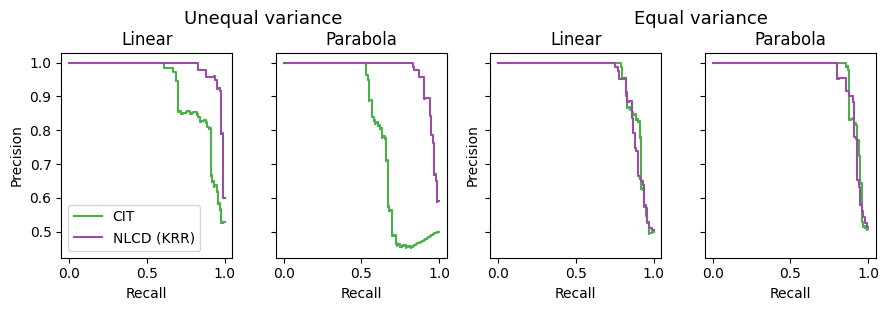

In [24]:
suppl_s5_a()

In [60]:
def suppl_s6():
    #### Supplementary Figure S6 ######
    nlcd_dir="./results/simulation/nlcd/"
    cit_dir="./results/simulation/cit/"
    norows=2
    nocols=2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    #fig.suptitle("Performance when the variance changes for sample sizes of 300 and 1000 ")
    color_purple  = sns.color_palette("Purples", 2)
    color_green = sns.color_palette("Greens", 2)
    plot_index = 0

    for j in ['Linearvar', 'Paravar','Linear','Para']:
        col_indx=0
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        for i in ['300', '1000'] :
        #for i in ['500']:
            for k in [ '100']: 
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_green[col_indx])

                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_green[col_indx])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_purple[col_indx])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_purple[col_indx])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Parabola')
                if(plot_index % nocols == 0):   # if its the second row then add the y labels 
                    curr_ax.set_ylabel('Precision')
                if(plot_index % nocols == 0 and plot_index // norows  == 0):  
                    curr_ax.set_ylabel('Unequal Variance \n Precision')
                if(plot_index % nocols == 0 and plot_index // norows  == 1):  
                    curr_ax.set_ylabel('Equal Variance \n Precision')
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                col_indx += 1
        if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
            xindex=norows-1
            yindex=0
            handles = [ax[xindex, yindex].lines[1], ax[xindex, yindex].lines[3],ax[xindex, yindex].lines[0], ax[xindex, yindex].lines[2]]
            labels = ['NLCD (300)','NLCD (1000)','CIT (300)','CIT (1000)']
            curr_ax.legend(handles,labels,loc="lower left")
            
                
        
        plot_index+=1

    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig4_var_suppl.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_var_suppl.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_var_suppl.pdf', bbox_inches='tight',format='pdf', dpi=1200)


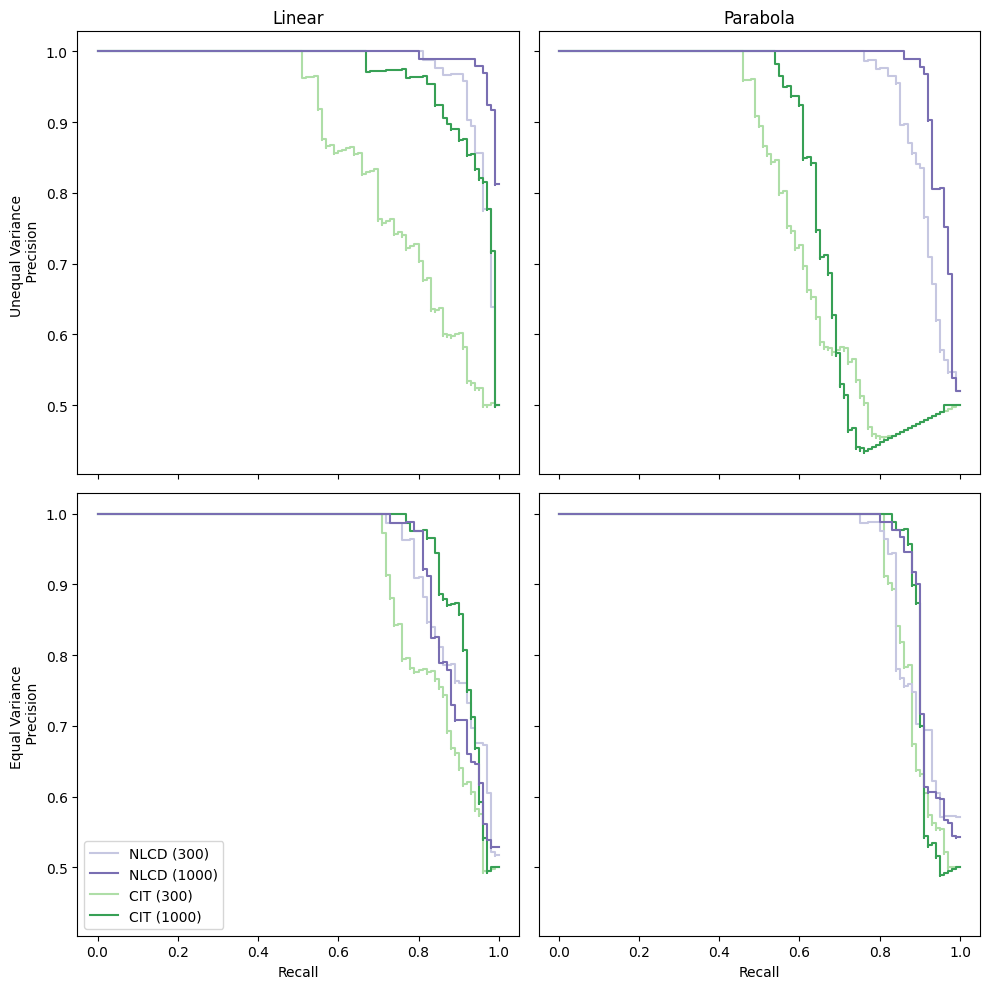

In [61]:
suppl_s6()

### Unequal variance parabola plotting

In [62]:
df=read_data('./data/Paravar500.txt')
i=4
A=df[i][1]
B=df[i][2]
L=df[i][0]

In [63]:
read_configuration('./data/Paravar500.txt').iloc[4,]
#order: b1,b2,a 

0    1
1    2
2    1
Name: 4, dtype: object

In [66]:
def suppl_s5_b():
    ######## Supplementary Figure S5 b ###########

    # b1=1 b2=2 a=1
    mu_0=0
    mu_1=1  ## a1*L + b1* epsilon1 + (1-L)*epsilon2 
    var_0=4
    var_1=1
    a=0.5

    print("Using the general formula true values")
    #x_min,x1,x2=overlap_endpoints_quadratic(0.7026203985498004,mu_0,mu_1,var_0,var_1,a)
    #x_min,x1,x2=overlap_endpoints_quadratic(0.8,mu_0,mu_1,var_0,var_1,a)
    #print("x min, x1, x2",x_min, x1, x2)
    x_max,x1,x2=overlap_endpoints_quadratic(0.2,mu_0,mu_1,var_0,var_1,a)
    print("x max, x1, x2",x_max,x1,x2)   
    #after observing the values, we will rewrite the x min and x max to get the band, note this is a specific case so change the code accordingly
    # in the next two lines 
    x_min= -1.1140370695529984
    x_max=3.780703736219665
    print(x_min,x_max)

    scatter=plt.scatter(A,B,c=L,alpha=0.5)
    plt.title("Parabola with unequal variance ")
    plt.xlabel('A')
    plt.ylabel('B')
    #plt.axvspan(xmin=-1, xmax=3, alpha=0.4, color='gray',label='Overlap') 
    plt.axvspan(xmin=x_min, xmax=x_max, alpha=0.4, color='gray',label='Overlap') 
    cmap = scatter.cmap  # Get the colormap
    norm = scatter.norm  # Get the normalization function
    custom_legends = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(0)), markersize=10, alpha=0.5, linestyle='', label='L=0'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(1)), markersize=10, alpha=0.5, linestyle='', label='L=1'),
        Line2D([0], [0], marker='o', color='red', markersize=10, alpha=0.7, linestyle='', label='L=0 pred'),
        Line2D([0], [0], marker='o', color='green', markersize=10, alpha=0.7, linestyle='', label='L=1 pred'),
        Patch(facecolor='gray', edgecolor='w', alpha=0.4, label='Overlap')  
    ]
    plt.legend(handles=custom_legends, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
    plt.tight_layout()
    #plt.savefig("./results/journal/plots/fig4_example.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_example.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_example.pdf', bbox_inches='tight',format='pdf', dpi=1200)

Using the general formula true values
value of r -0.375
x max, x1, x2 3.780703736219665 -1.1140370695529984 3.780703736219665
-1.1140370695529984 3.780703736219665


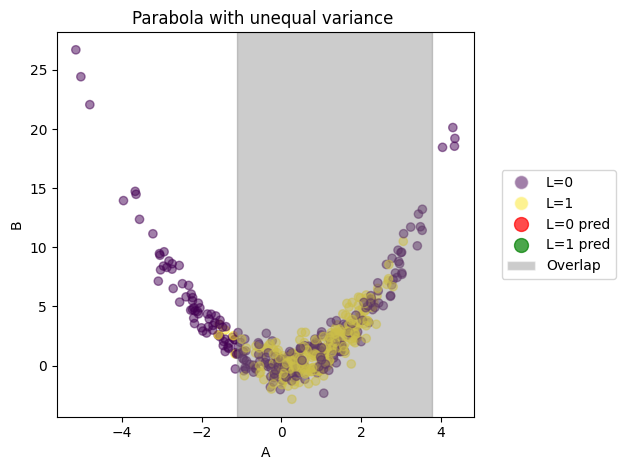

In [67]:
suppl_s5_b()

In [68]:
def suppl_s5_c():
    # Parabola 500: i=4 for example 

    plt.title("Plot of L=0 and L=1 predictions of NLCD on the data")
    scatter=plt.scatter(A,B,c=L,alpha=0.5)
    plt.xlabel('A')
    plt.ylabel('B')
    y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
    plt.scatter(A,y_pred_original[0],label='L=0 pred',alpha=0.7,color='red')
    plt.scatter(A,y_pred_original[1],label='L=1 pred',alpha=0.7,color='green')

    plt.axvspan(xmin=-1.1140370695529984, xmax=3.780703736219665, alpha=0.3, color='gray',label='Overlap') 
    # Custom legend items
    cmap = scatter.cmap  # Get the colormap
    norm = scatter.norm  # Get the normalization function


    # Show the plot
    plt.tight_layout()
    #plt.savefig("./results/journal/plots/fig4_example_L.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_example_L.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_example_L.pdf', bbox_inches='tight',format='pdf', dpi=1200)

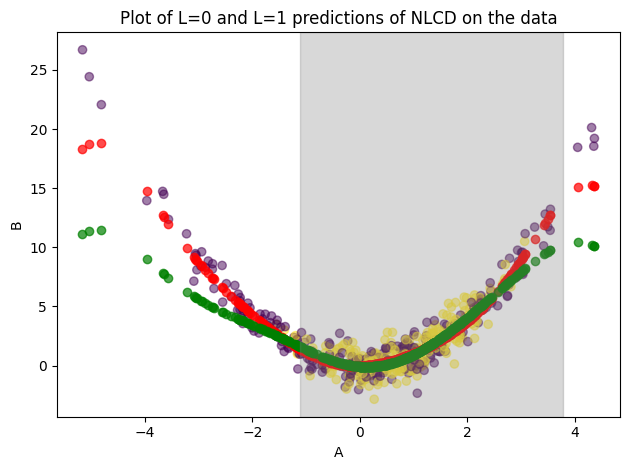

In [69]:
suppl_s5_c()

In [72]:
def suppl_s5_d():
    #CIT L example
    B_values=pd.read_csv('./figures/B_columns_cit_para_example_L.csv')

    plt.title("Plot of L=0 and L=1 predictions of CIT on the data")
    scatter=plt.scatter(A,B,c=L,alpha=0.5)
    plt.xlabel('A')
    plt.ylabel('B')
    #y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
    plt.scatter(A,B_values.iloc[:,0],label='L=0 pred',alpha=0.7,color='red')
    plt.scatter(A,B_values.iloc[:,1],label='L=1 pred',alpha=0.7,color='green')
    plt.axvspan(xmin= -1.1140370695529984, xmax= 3.780703736219665, alpha=0.3, color='gray',label='Overlap') 
    # Custom legend items
    cmap = scatter.cmap  # Get the colormap
    norm = scatter.norm  # Get the normalization function

    # Show the plot
    plt.tight_layout()
    #plt.savefig("./results/journal/plots/fig4_example_L_CIT.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_example_L_CIT.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_example_L_CIT.pdf', bbox_inches='tight',format='pdf', dpi=1200)


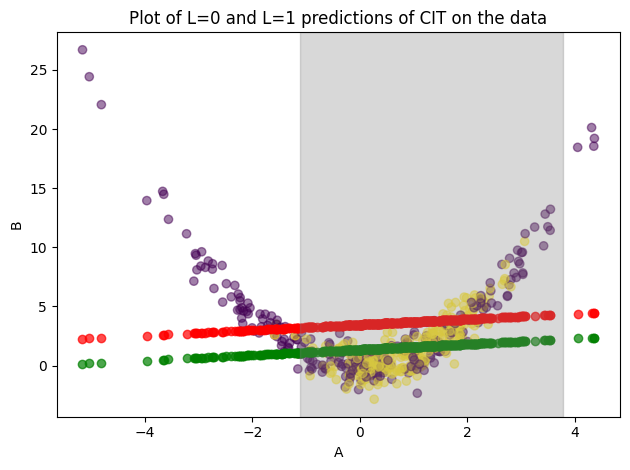

In [73]:
suppl_s5_d()

### Note for Human plots: The computation of NLCD is already done and the results are saved. The saved result is loaded here to plot the causal pairs. This is done since the genotype access is protected.

In [75]:
df=read_data('/data/users/cs20s037/CITNonLinear/conclude/newmethod/simulation_final/gtex/muscle/human_muscle_deseq.txt')
dfconf=read_configuration('/data/users/cs20s037/CITNonLinear/conclude/newmethod/simulation_final/gtex/muscle/human_muscle_deseq.txt')
i=3769
A=df[i][1]
B=df[i][2]
L=df[i][0]

In [76]:
dfconf[dfconf[1].str.contains(f'^.*ENSG00000125347', regex=True)]
#checking if 3769 is the right id 

,0,1,2
3758,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000231925.11
3759,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000123609.10
3760,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000178685.13
3761,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000164136.16
3762,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000133321.10
3763,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000136147.17
3764,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000169871.12
3765,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000123992.18
3766,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000164307.12
3767,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000060491.16


In [ ]:
def fig5_b():
    ##### Figure 5 b #######
    #plt.title("Plot of L=0 and L=1 predictions of NLCD on the data")
    plt.scatter(A,B,c=L,alpha=0.5)
    plt.xlabel('ENSG00000125347 (IRF1)')
    plt.ylabel('ENSG00000092010 (PSME 1)')
    y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
    plt.scatter(A,y_pred_original[0],label='L=0 pred',color='red',s=5)
    plt.scatter(A,y_pred_original[1],label='L=1 pred',color='green',s=5)
    plt.scatter(A,y_pred_original[2],label='L=2 pred',color='black',s=5)
    plt.legend()
    #plt.savefig("./results/journal/plots/human_irf.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/human_irf.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/human_irf.pdf', bbox_inches='tight',format='pdf', dpi=1200)

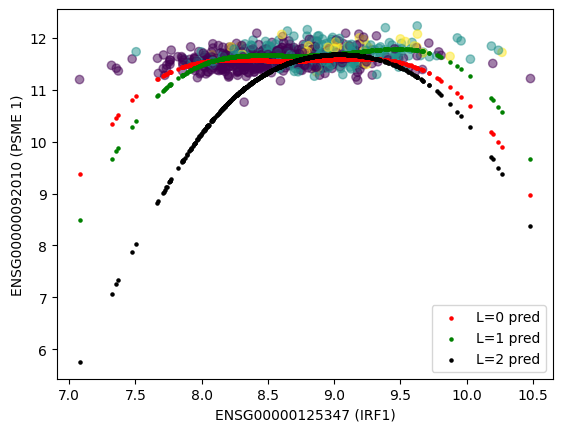

In [80]:
fig5_b()

In [81]:
def fig5_c():
    ##### figure 5 c #########
    x_min=8.5
    x_max=9
    y_min=10
    y_max=12.5
    plt.scatter(A,B,c=L,alpha=0.5)
    plt.xlabel('ENSG00000125347 (IRF1)')
    plt.ylabel('ENSG00000092010 (PSME 1)')
    y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
    plt.scatter(A,y_pred_original[0],label='L=0 pred',color='red',s=5)
    plt.scatter(A,y_pred_original[1],label='L=1 pred',color='green',s=5)
    plt.scatter(A,y_pred_original[2],label='L=2 pred',color='black',s=5)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    #plt.savefig("./results/journal/plots/human_irf_zoomed.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/human_irf_zoomed.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/human_irf_zoomed.pdf', bbox_inches='tight',format='pdf', dpi=1200)

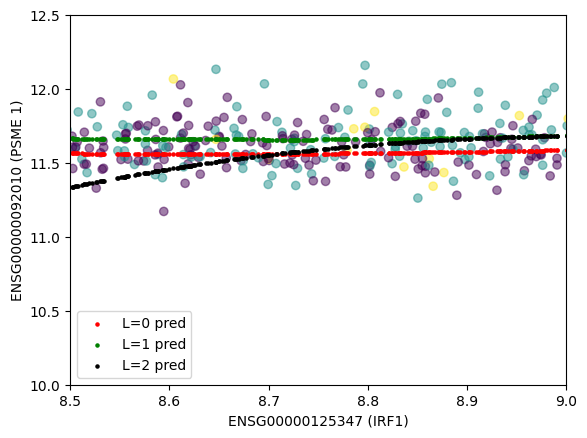

In [82]:
fig5_c()

In [84]:
## negative example, correlated but no causation
## IRF1 and PARP10 test3 value 0.034 but test4 0.2380
df=read_data('/data/users/cs20s037/CITNonLinear/conclude/newmethod/simulation_final/gtex/muscle/human_muscle_deseq.txt')
dfconf=read_configuration('/data/users/cs20s037/CITNonLinear/conclude/newmethod/simulation_final/gtex/muscle/human_muscle_deseq.txt')
i=3760
A=df[i][1]
B=df[i][2]
L=df[i][0]

In [ ]:
def fig5_d():
    ######### Figure 5 d ##########
    #plt.title("Plot of L=0 and L=1 predictions of NLCD on the data")
    plt.scatter(A,B,c=L,alpha=0.5)
    plt.xlabel('ENSG00000125347 (IRF1)')
    plt.ylabel('ENSG00000178685 (PARP10)')
    y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
    plt.scatter(A,y_pred_original[0],label='L=0 pred',color='red',s=5)
    plt.scatter(A,y_pred_original[1],label='L=1 pred',color='green',s=5)
    plt.scatter(A,y_pred_original[2],label='L=2 pred',color='black',s=5)
    plt.legend()
    #plt.savefig("./results/journal/plots/human_irf_neg.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/human_irf_neg.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/human_irf_neg.pdf', bbox_inches='tight',format='pdf', dpi=1200)

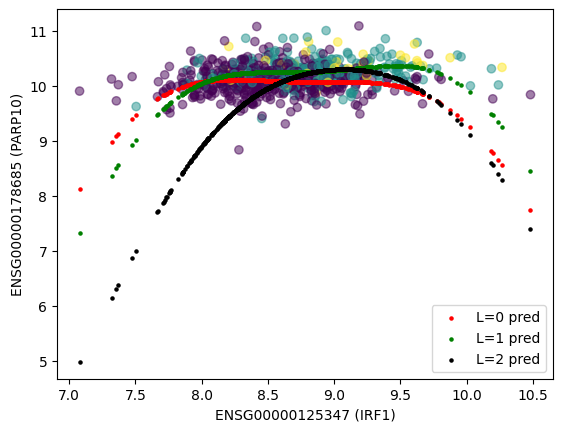

In [86]:
fig5_d()

In [ ]:
def fig5_e():
    ###### Figure 5 e #########
    #negative example zoom
    x_min=8.5
    x_max=9.5
    y_min=9
    y_max=11
    plt.scatter(A,B,c=L,alpha=0.5)
    plt.xlabel('ENSG00000125347 (IRF1)')
    plt.ylabel('ENSG00000178685 (PARP10)')
    y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
    plt.scatter(A,y_pred_original[0],label='L=0 pred',color='red',s=5)
    plt.scatter(A,y_pred_original[1],label='L=1 pred',color='green',s=5)
    plt.scatter(A,y_pred_original[2],label='L=2 pred',color='black',s=5)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    #plt.savefig("./results/journal/plots/human_irf_neg_zoomed.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/human_irf_neg_zoomed.svg', bbox_inches='tight',format='svg', dpi=1200)
    #plt.savefig('./results/journal/plots/human_irf_neg_zoomed.pdf', bbox_inches='tight',format='pdf', dpi=1200)

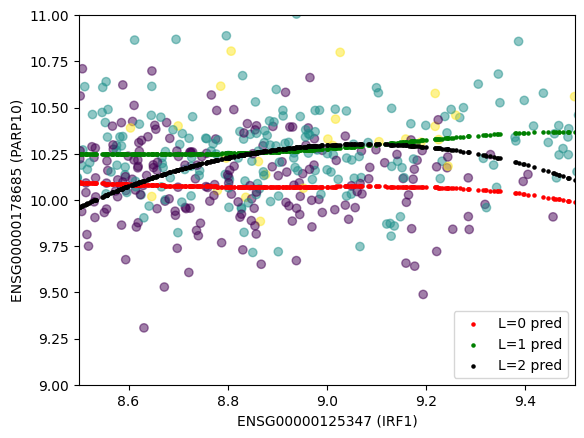

In [88]:
fig5_e()

In [13]:
def yeastbarplot_all_methods_unequal_nonlinear(bcmi_cutoff,run_no=1,seed=1):
    ###### Function for figure 4b and S10 ########
    
    # yeast calculate the avg precision score for all variance for each subset different varaince 
    ### yeast analysis ################
    #cutoffs=[0,0.1,0.15,0.2,0.25]
    cutoffs=[0,0.05,0.1,0.15]
    odc_cutoff=0.05
    cit_10run_dir="/data/users/cs20s037/CITNonLinear/results/cit_nlcd_yeast/wilko10runs/cit/"
    nlcd_10run_dir="/data/users/cs20s037/CITNonLinear/results/cit_nlcd_yeast/wilko10runs/nlcd/"
    findr_yeast_dir="/data/users/cs20s037/CITNonLinear/results/findr_yeast/"
    mrpc_yeast_dir="/data/users/cs20s037/CITNonLinear/results/mrpc_yeast/yeast_indv/"
    varandnonlinear_dir="/data/users/cs20s037/CITNonLinear/yeast/varandnonlinear_indices/"

    nlcd_mean=[]
    cit_mean=[]
    findr_mean=[]
    mrpc_mean=[]
    nlcd_std=[]
    cit_std=[]
    findr_std=[]
    mrpc_std=[]
    random_classifier=[]
    causal_number=[]
    indep_number=[]
    for j in range(len(cutoffs)):
        nlcd_avgprecision=[]
        cit_avgprecision=[]
        findr_avgprecision=[]
        mrpc_avgprecision=[]
        nlcd_auc=[]
        mrpc_auc=[]
        cit_auc=[]
        findr_auc=[]

        #varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/var_indices/yeast_wilko_var_causal_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
        #varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/var_indices/yeast_wilko_var_indep_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
        #varcausalyeast=list(set(varcausalyeast).intersection(set(possiblecausallist)))
        #varindepyeast=list(set(varindepyeast).intersection(set(possibleindplist)))
        #print("other values print")
        for i in range(1,2):
            #print("Run ",i)
            varcausalyeast=pd.read_csv(varandnonlinear_dir+"seed"+str(seed) + "/yeast_causal_var" + str(cutoffs[j]) + "bcmi" + str(bcmi_cutoff)+"_"+str(odc_cutoff)+".csv",header=None)[0].to_list()
            varindepyeast=pd.read_csv(varandnonlinear_dir+"seed"+str(seed) + "/yeast_indep_var" + str(cutoffs[j]) + "bcmi" + str(bcmi_cutoff)+"_"+str(odc_cutoff)+".csv",header=None)[0].to_list()
            other_values=pd.read_csv(varandnonlinear_dir+"seed"+str(seed) + "/yeast_other_var" + str(cutoffs[j]) + "bcmi" + str(bcmi_cutoff)+"_"+str(odc_cutoff)+".csv",header=None)[0].to_list()
            #print(other_values)
            avgprecision=calculate_avgprecision(nlcd_10run_dir+"yeast_causal"+str(run_no)+".csv", nlcd_10run_dir+"yeast_indp"+str(run_no)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            nlcd_avgprecision.append(avgprecision)
            #print("NLCD avg precision ", avgprecision)
            avgprecision=calculate_avgprecision(cit_10run_dir+"yeast_causal_"+str(run_no)+".csv", cit_10run_dir+"yeast_indp_"+str(run_no)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            #print("CIT avg precision",avgprecision)
            cit_avgprecision.append(avgprecision)
            avgprecision=calculate_avgprecision_findr(findr_yeast_dir+"yeast_1_1752_findr.csv",findr_yeast_dir+"yeast_0_1752_findr.csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            findr_avgprecision.append(avgprecision)
            avgprecision=calculate_avgprecision_MRPC(mrpc_yeast_dir+"1_trios_mrpc.csv",mrpc_yeast_dir+"0_trios_mrpc.csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            mrpc_avgprecision.append(avgprecision)

            precision_CIT, recall_CIT = calculate_precision_recall(cit_10run_dir+"yeast_causal_"+str(run_no)+".csv", cit_10run_dir+"yeast_indp_"+str(run_no)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_10run_dir+"yeast_causal"+str(run_no)+".csv", nlcd_10run_dir+"yeast_indp"+str(run_no)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            precision_findr,recall_findr=calculate_precision_recall_findr(findr_yeast_dir+"yeast_1_1752_findr.csv",findr_yeast_dir+"yeast_0_1752_findr.csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            precision_mrpc,recall_mrpc=calculate_precision_recall_MRPC(mrpc_yeast_dir+"1_trios_mrpc.csv",mrpc_yeast_dir+"0_trios_mrpc.csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            auc_score = auc(recall_nlmr_KRR, precision_nlmr_KRR)
            #print("NLCD AUPR ",auc_score)
            nlcd_auc.append(auc_score)
            auc_score = auc(recall_CIT, precision_CIT)
            #print("CIT AUPR ",auc_score)
            cit_auc.append(auc_score)
            auc_score=auc(recall_findr,precision_findr)
            findr_auc.append(auc_score)
            #auc_score=auc(recall_mrpc,precision_mrpc)
            #mrpc_auc.append(auc_score)
        #print("other values print stop")
        nlcd_mean.append(np.mean(nlcd_avgprecision))
        cit_mean.append(np.mean(cit_avgprecision))
        findr_mean.append(np.mean(findr_avgprecision))
        mrpc_mean.append(np.mean(mrpc_avgprecision))
        nlcd_std.append(np.std(nlcd_avgprecision))
        cit_std.append(np.std(cit_avgprecision))
        findr_std.append(np.std(findr_avgprecision))
        mrpc_std.append(np.std(mrpc_avgprecision))
        random_classifier.append(other_values[2])
        causal_number.append(other_values[0])
        indep_number.append(other_values[1])

    nlcd_mean=np.round(nlcd_mean,2)
    cit_mean=np.round(cit_mean,2)
    findr_mean=np.round(findr_mean,2)
    mrpc_mean=np.round(mrpc_mean,2)
    random_classifier=np.round(random_classifier,2)
    print(random_classifier)
    print(causal_number)
    print(indep_number)
    species = cutoffs
    algo_means = {
        'CIT': cit_mean,
        'NLCD': nlcd_mean,
        'Findr':findr_mean,
        'MRPC':mrpc_mean,
        'random':random_classifier
    }

    x = np.arange(len(species))  # the label locations
    width = 0.15  # the width of the bars, change this if the numbers are overlapping 
    multiplier = 0

    fig, ax = plt.subplots(figsize=(10, 6))

    for attribute, measurement in algo_means.items():
        offset = width * multiplier
        if attribute=='CIT':
            #rects = ax.bar(x + offset, measurement, width, yerr=cit_std,label=attribute,color='green',capsize=4)
            rects = ax.bar(x + offset, measurement, width,label=attribute,color='green',capsize=4)
        elif attribute=='NLCD':
            #rects = ax.bar(x + offset, measurement, width, yerr=nlcd_std,label=attribute,color='purple',capsize=4)  
            rects = ax.bar(x + offset, measurement, width,label=attribute,color='purple',capsize=4)      
        elif attribute=='Findr':
            #rects = ax.bar(x + offset, measurement, width, yerr=findr_std,label=attribute,color='orange',capsize=4)  
            rects = ax.bar(x + offset, measurement, width,label=attribute,color='orange',capsize=4)   
        elif attribute=='MRPC':
            #rects = ax.bar(x + offset, measurement, width, yerr=mrpc_std,label=attribute,color='yellow',capsize=4)  
            rects = ax.bar(x + offset, measurement, width,label=attribute,color='yellow',capsize=4)
        else:
            rects = ax.bar(x + offset, measurement, width,label=attribute,color='black',capsize=4)
          

        ax.bar_label(rects, padding=5)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUPRC')
    #ax.set_title(r'Average Precision Score across 10 runs with varying Extent of unequal variance ($\Delta\mathrm{var}$)')
    ax.set_xlabel(r'Extent of unequal variance ($\Delta\mathrm{var}$)')
    #ax.set_xticks(x + width/2, [0,0.1,0.125,0.15,0.175,0.2,0.225,0.25])
    #ticks=[0,0.1,0.125,0.15,0.175,0.2,0.225,0.25]
    ticks=[0,0.05,0.1,0.15]
    #xtick_labels = [f"{var1}\nCausal trios {var2}Independent trios\n{var3}" for var1, var2, var3 in zip(ticks, causal_number,indep_number)]
    xtick_labels = [f"Cutoffs: {var1}\nCausal triplets: {int(var2)}\nIndependent triplets: {int(var3)}" 
                if index == 1 else f"{var1}\n{int(var2)}\n{int(var3)}" 
                for index, (var1, var2, var3) in enumerate(zip(ticks, causal_number, indep_number), 1)]
    ax.set_xticks(x + 2*width, labels=xtick_labels)
    ax.legend(loc='upper left', ncol=2)
    ax.set_ylim(0, 1)
    #print(np.round(np.mean(nlcd_std),4))
    #print(np.round(np.mean(cit_std),4))
    #print(np.round(np.mean(findr_std),4))
    #print(np.round(np.mean(mrpc_std),4))
    print(random_classifier)
    fig.tight_layout()
    #plt.savefig("./results/journal/plots/figyeast_bar_apr_allmethod_unequalwcutoff_seed" + str(seed)+".png", bbox_inches='tight', dpi=1200)
    #plt.savefig("./results/journal/plots/figyeast_bar_apr_allmethod_unequalwcutoff_seed"+str(seed)+".svg", bbox_inches='tight', format='svg', dpi=1200)
    plt.savefig("/data/users/cs20s037/CITNonLinear/conclude/newmethod/simulation_final/results/journal/plots/yeast_variance_seed_"+str(seed)+".pdf", bbox_inches='tight', format='pdf', dpi=1200)


In [93]:
import random
# Set the seed
random.seed(47)

# Generate a random number between 1 and 10
random_number = random.randint(1, 10)
print(random_number)
random_number = random.randint(1, 10)
print(random_number)

6
2


[0.5  0.54 0.58 0.39]
[63.0, 54.0, 54.0, 12.0]
[63.0, 46.0, 39.0, 19.0]
[0.5  0.54 0.58 0.39]


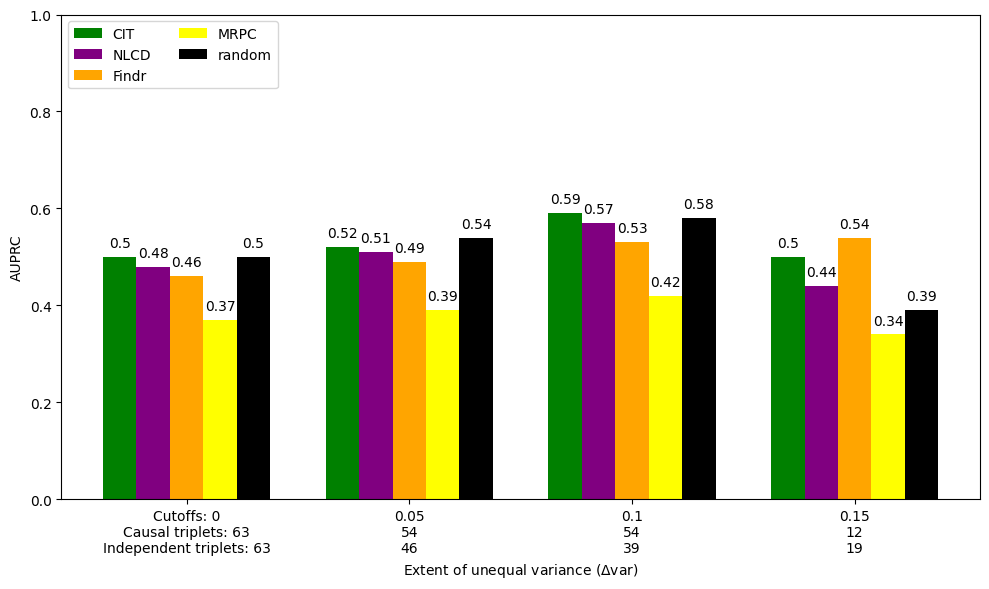

In [14]:
yeastbarplot_all_methods_unequal_nonlinear(bcmi_cutoff=0.05,run_no=1,seed=6)

[0.5  0.53 0.55 0.32]
[63.0, 54.0, 54.0, 12.0]
[63.0, 47.0, 45.0, 26.0]
[0.5  0.53 0.55 0.32]


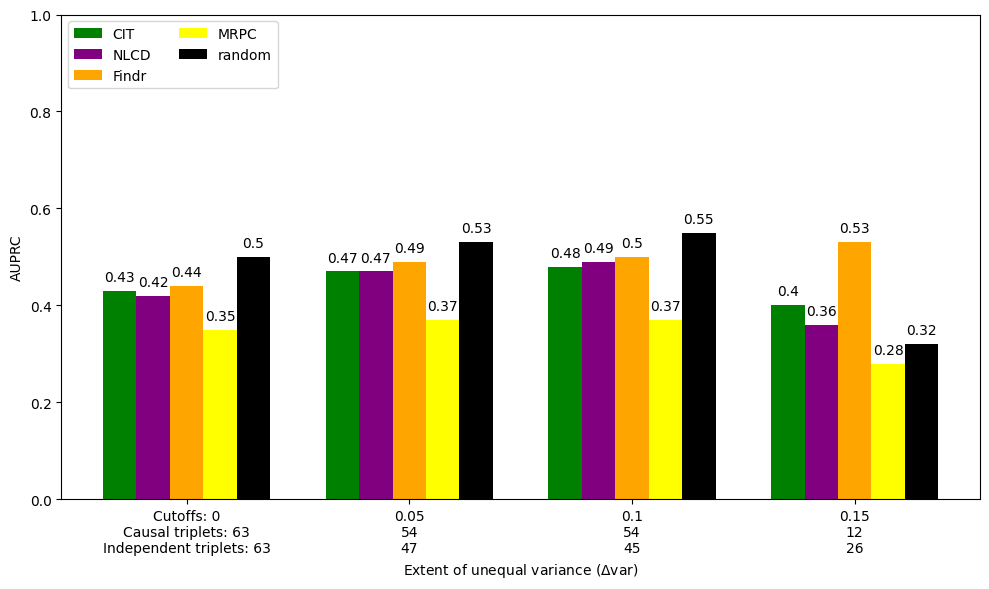

In [15]:
yeastbarplot_all_methods_unequal_nonlinear(bcmi_cutoff=0.05,run_no=1,seed=2)


In [ ]:
def fig4_b(y,cutoff,p_values):
    ######## Figure 4 b & c ############

    # yeast calculate the avg precision score for all variance for each subset different variance 
    ### yeast analysis ################
    cutoffs = [cutoff]
    #p_values = ['both']
    #p_values = ['both','bcmi', 'spear']
    p_values=p_values
    cit_10run_dir="./results/cit_nlcd_yeast/wilko10runs/cit/"
    nlcd_10run_dir="./results/cit_nlcd_yeast/wilko10runs/nlcd/"
    findr_yeast_dir="./results/findr_yeast/"
    mrpc_yeast_dir="./results/mrpc_yeast/yeast_indv/"
    mpmi_dir="./yeast/mpmi_indices/"
    #p_values = [ 'both']
    l_values = [0.05, 0.1, 0.15]
    spearman_causal=pd.read_csv(mpmi_dir+"spearman_cutoff_causal.txt",header=None)[0].to_list()
    #spearman_indep=pd.read_csv(mpmi_dir+"spearman_cutoff_indep.txt",header=None)[0].to_list()
    fig, axs = plt.subplots(len(p_values), len(l_values), figsize=(6, 8),sharex=True,sharey=True)
    #fig.suptitle(r'Average Precision Score across 10 seeds for a given run varying ($\Delta\mathrm{var}$)')
    fig.suptitle(rf'Extent of nonlinearity of ${cutoff}$')
    for p_index, p in enumerate(p_values):
        for l_index, l in enumerate(l_values):
            nlcd_mean=[]
            cit_mean=[]
            findr_mean=[]
            mrpc_mean=[]
            nlcd_std=[]
            cit_std=[]
            findr_std=[]
            mrpc_std=[]
            for j in range(len(cutoffs)):
                nlcd_avgprecision=[]
                cit_avgprecision=[]
                findr_avgprecision=[]
                mrpc_avgprecision=[]
                nlcd_auc=[]
                cit_auc=[]
                findr_auc=[]
                mrpc_auc=[]
                # backup2 has the older files which was a bug 
                #varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/backup2/yeast_wilko_mi_causal_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                #varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/backup2/yeast_wilko_mi_indep_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                for i in range(1,11):
                    varcausalyeast=pd.read_csv(mpmi_dir+'seed'+str(i)+'/yeast_wilko_mi_causal_'+p+str(l)+'_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                    varindepyeast=pd.read_csv(mpmi_dir+'seed'+str(i)+'/yeast_wilko_mi_indep_'+p+str(l)+'_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                
                    #print("Run ",i)
                    avgprecision=calculate_avgprecision(nlcd_10run_dir+"yeast_causal"+str(y)+".csv", nlcd_10run_dir+"yeast_indp"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    nlcd_avgprecision.append(avgprecision)
                    #print("NLCD avg precision ", avgprecision)
                    avgprecision=calculate_avgprecision(cit_10run_dir+"yeast_causal_"+str(y)+".csv", cit_10run_dir+"yeast_indp_"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    #print("CIT avg precision",avgprecision)
                    cit_avgprecision.append(avgprecision)
                    avgprecision=calculate_avgprecision_findr(findr_yeast_dir+"yeast_1_1752_findr.csv",findr_yeast_dir+"yeast_0_1752_findr.csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    findr_avgprecision.append(avgprecision)
                    avgprecision=calculate_avgprecision_MRPC(mrpc_yeast_dir+"1_trios_mrpc.csv",mrpc_yeast_dir+"0_trios_mrpc.csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    mrpc_avgprecision.append(avgprecision)

                    precision_CIT, recall_CIT = calculate_precision_recall(cit_10run_dir+"yeast_causal_"+str(y)+".csv", cit_10run_dir+"yeast_indp_"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_10run_dir+"yeast_causal"+str(y)+".csv", nlcd_10run_dir+"yeast_indp"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    precision_findr,recall_findr=calculate_precision_recall_findr(findr_yeast_dir+"yeast_1_1752_findr.csv",findr_yeast_dir+"yeast_0_1752_findr.csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    precision_mrpc,recall_mrpc=calculate_precision_recall_MRPC(mrpc_yeast_dir+"1_trios_mrpc.csv",mrpc_yeast_dir+"0_trios_mrpc.csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    auc_score = auc(recall_nlmr_KRR, precision_nlmr_KRR)
                    #print("NLCD AUPR ",auc_score)
                    nlcd_auc.append(auc_score)
                    auc_score = auc(recall_CIT, precision_CIT)
                    #print("CIT AUPR ",auc_score)
                    cit_auc.append(auc_score)
                    auc_score=auc(recall_findr,precision_findr)
                    findr_auc.append(auc_score)
                    #auc_score=auc(recall_mrpc,precision_mrpc)
                    #mrpc_auc.append(auc_score)

                nlcd_mean.append(np.mean(nlcd_avgprecision))
                cit_mean.append(np.mean(cit_avgprecision))
                findr_mean.append(np.mean(findr_avgprecision))
                mrpc_mean.append(np.mean(mrpc_avgprecision))
                nlcd_std.append(np.std(nlcd_avgprecision))
                cit_std.append(np.std(cit_avgprecision))
                findr_std.append(np.std(findr_avgprecision))
                mrpc_std.append(np.std(mrpc_avgprecision))

            nlcd_mean=np.round(nlcd_mean,2)
            cit_mean=np.round(cit_mean,2)
            findr_mean=np.round(findr_mean,2)
            mrpc_mean=np.round(mrpc_mean,2)

            species = cutoffs
            
            algo_means = {
                'CIT': cit_mean,
                'NLCD': nlcd_mean,
                'Findr':findr_mean,
                'MRPC':mrpc_mean
            }
            #species=list(algo_means.keys())

            x = np.arange(len(species))  # the label locations
            width = 0.2  # the width of the bars , change this if the numbers are overlapping 
            multiplier = 0
            
            
            #fig, ax = plt.subplots(figsize=(10, 6),layout='constrained')
            #ax=axs[l_index]
            ax=axs[p_index,l_index]
            #ax=axs[l_index]
            for attribute, measurement in algo_means.items():
                offset = width * multiplier
                if attribute=='CIT':
                    rects = ax.bar(x + offset, measurement, width, yerr=cit_std,label=attribute,color='green',capsize=4)
                elif attribute=='NLCD':
                    rects = ax.bar(x + offset, measurement, width, yerr=nlcd_std,label=attribute,color='purple',capsize=4)    
                elif attribute=='Findr':
                    rects = ax.bar(x + offset, measurement, width, yerr=findr_std,label=attribute,color='orange',capsize=4)     
                else:
                    rects = ax.bar(x + offset, measurement, width, yerr=mrpc_std,label=attribute,color='yellow',capsize=4)   
                ax.bar_label(rects, padding=5)
                multiplier += 1

            # Add some text for labels, title and custom x-axis tick labels, etc.
            #ax.set_ylabel('Average precision score')
            #ax.set_title(r'Average Precision Score across 10 runs with varying Extent of nonlinearity ($\Delta\mathrm{var}$)')
            #ax.set_xlabel("Extent of nonlinearity")
            if(p=='both'):
                ax.set_title(fr' BCMI > {l} or $|\rho|$ > {np.round(spearman_causal[l_index],3)} ',fontsize=8)
            elif(p=='bcmi'):
                ax.set_title(f' BCMI > {l} ')
            elif(p=='spear'):
                ax.set_title(fr' $|\rho|$ > {np.round(spearman_causal[l_index],3)} ')
            #ax.set_ylim(0.3, 0.9)
            ax.set_xticks([0,0.2,0.4,0.6])
            #if(p=='bcmi' and l==0.05):
            #    ax.legend(loc='upper left', ncol=2)
            #    ax.set_ylabel('Bcmi')
            if( l==0.05):
                ax.set_ylabel('AUPRC')
            #ax.set_ylabel
            #if(p=='spear' and l==0.05):
            #    ax.set_ylabel('Average precision score \n spearman')
            ax.set_xticklabels(algo_means.keys(),rotation=-90) 
            #if( l==0.1):
            #    ax.set_xlabel("Extent of nonlinearity")

            ax.set_ylim(0.3, 1)

    fig.tight_layout()
    #fig.text(0.5, 0.08, "Extent of nonlinearity ODC cutoff", ha='center')
    #fig.text(0.08, 0.5, 'Average Precision Score', va='center', rotation='vertical')
    #plt.savefig("./results/temp_seeds_yeast/figyeast_bar_nlr_seedyeast_first_"+str(y)+"_all_remsupp_"+str(cutoff)+".png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/figyeast_bar_nlr_seedyeast_first_'+str(y)+'_all_remsupp_'+str(cutoff)+'.svg', bbox_inches='tight', format='svg', dpi=1200)
    #plt.savefig('/data/users/cs20s037/CITNonLinear/conclude/newmethod/simulation_final/results/journal/plots/fig4_b'+'_ExtentON_'+str(cutoff)+'.pdf', bbox_inches='tight', format='pdf', dpi=1200)


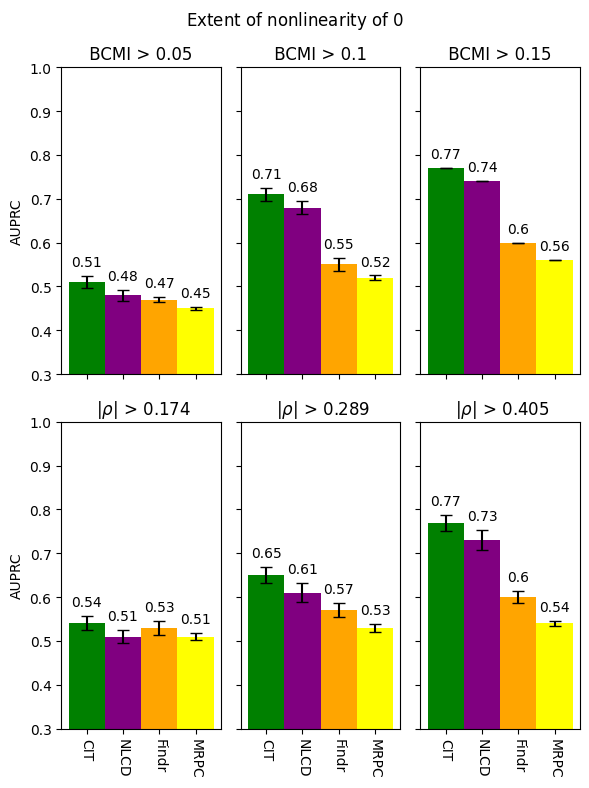

In [80]:
###### Supplementary Figure S9 b  #############
fig4_b(1,0, ['bcmi', 'spear'])

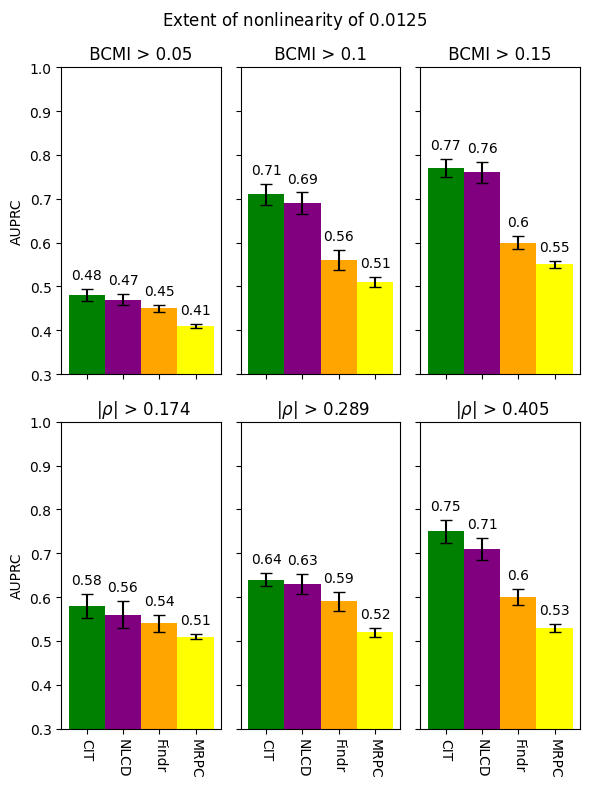

In [81]:
fig4_b(1,0.0125, ['bcmi', 'spear'])

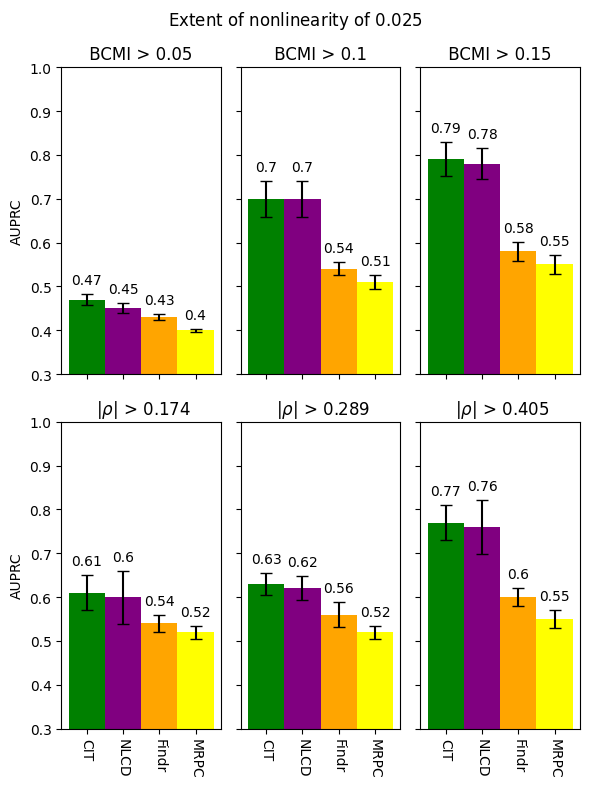

In [82]:
fig4_b(1,0.025, ['bcmi', 'spear'])

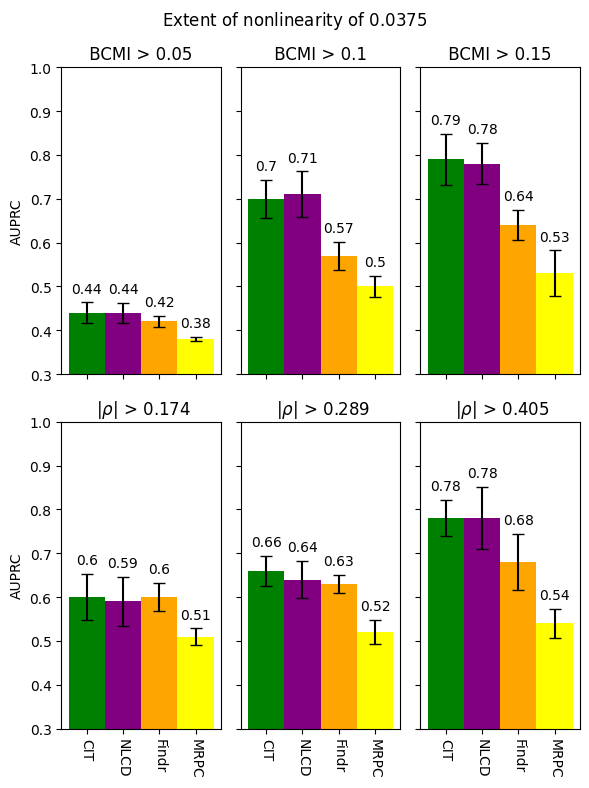

In [83]:
fig4_b(1,0.0375, ['bcmi', 'spear'])

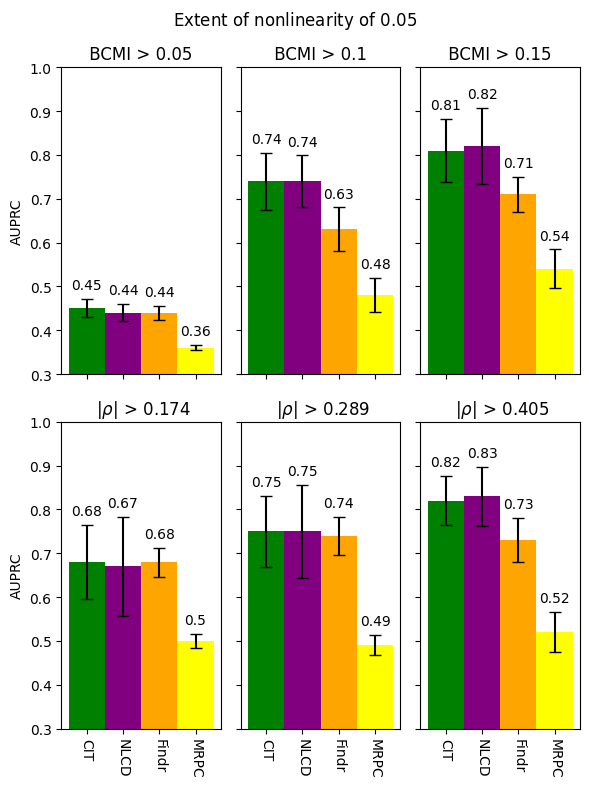

In [84]:
fig4_b(1,0.05, ['bcmi', 'spear'])

In [ ]:
def yeastpr_all_method():
    ######### Supplementary Figure S7 ################
    cit_dir="./results/cit_nlcd_yeast/wilko100/cit/"
    nlcd_dir="./results/cit_nlcd_yeast/wilko500/nlcd/"
    findr_dir="./results/findr_yeast/"
    mrpc_dir="./results/mrpc_yeast/yeast_indv/"


    precision_CIT, recall_CIT = calculate_precision_recall(cit_dir+"yeast_causal_1752.csv",cit_dir+"yeast_indp_1752.csv")
    precision_CIT,recall_CIT=davis_goadrich_interpolation(precision_CIT,recall_CIT,positive=1752)
    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir+"yeast_causal_1752.csv",nlcd_dir+"yeast_indp_1752.csv")
    precision_nlmr_KRR,recall_nlmr_KRR=davis_goadrich_interpolation(precision_nlmr_KRR,recall_nlmr_KRR,positive=1752)
    precision_findr,recall_findr=calculate_precision_recall_findr(findr_dir+"yeast_1_1752_findr.csv",findr_dir+"yeast_0_1752_findr.csv")
    precision_findr,recall_findr=davis_goadrich_interpolation(precision_findr,recall_findr,positive=1752)
    precision_mrpc,recall_mrpc=calculate_precision_recall_MRPC(mrpc_dir+'1_trios_mrpc.csv',mrpc_dir+'0_trios_mrpc.csv')
    precision_mrpc,recall_mrpc=davis_goadrich_interpolation(precision_mrpc,recall_mrpc,positive=1752)


    fig, ax = plt.subplots()
    # Plot Precision-Recall curves using PrecisionRecallDisplay
    disp_nlmr_KRR = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
    disp_CIT = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
    disp_findr = PrecisionRecallDisplay(precision=precision_findr, recall=recall_findr)
    disp_mrpc = PrecisionRecallDisplay(precision=precision_mrpc, recall=recall_mrpc)

    disp_nlmr_KRR.plot(ax=ax,color=color_algo['KRR'], label='NLCD (KRR)')
    disp_CIT.plot(ax=ax,color=color_algo['CIT'], label='CIT (baseline)')
    disp_findr.plot(ax=ax,color=color_algo['findr'], label='findr')
    disp_mrpc.plot(ax=ax,color=color_algo['mrpc'], label='mrpc')

    ax.set_xlabel("Recall")
    ax.set_ylabel('Precision')
    #ax.set_title("Yeast Precision-Recall Plot for all the methods")
    ax.legend(loc="upper right")
    ax.set_ylim((0,1))
    randomclassifier=1752/(1752+1752)
    ax.axline((0, randomclassifier), (1, randomclassifier), linewidth=1, color='b',linestyle='--')
    plt.tight_layout()

    #plt.savefig("./results/journal/plots/yeast_allmethods.png", bbox_inches='tight', dpi=1200)
    #plt.savefig("./results/journal/plots/yeast_allmethods.jpg", bbox_inches='tight', dpi=1200)
    #plt.savefig("./results/journal/plots/yeast_allmethods.svg", bbox_inches='tight', dpi=1200)
    #plt.savefig("/data/users/cs20s037/CITNonLinear/conclude/newmethod/simulation_final/results/journal/plots/yeast_allmethods_1752.pdf", bbox_inches='tight', dpi=1200)


  

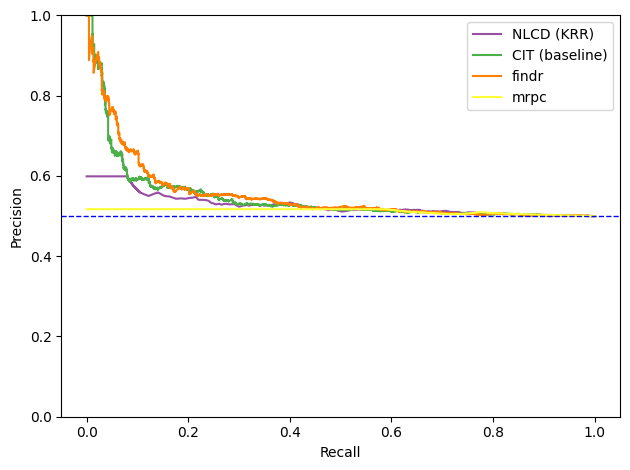

In [88]:
yeastpr_all_method()

### Average Precision of all the methods

In [ ]:

def find_aupr_average_precision():
    ###### Table S2 ###########

    ### Figure round_digit ################
    nlcd_dir="./results/simulation/nlcd/"
    cit_dir="./results/simulation/cit/"
    findr_dir="./results/simulation/findr/"
    mrpc_dir="./results/simulation/mrpc/sim_results/edges_robust/"
    round_digit=3

    for i in [ '300','500','1000'] :
        for j in ['Linear', 'Sine', 'Saw']:
            print("Data type: ", j)
            print("Sample size",i)
            for k in [ '500']: # put 100 permutations in supplementary 
                #precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                #print('nlcd SVR ',round(calculate_avgprecision(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv"),round_digit))
              
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                print('nlcd krr ',round(calculate_avgprecision(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv"),round_digit))
             
                #precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                #print('nlcd ann ',round(calculate_avgprecision(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv"),round_digit))
             
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                print('cit ',round(calculate_avgprecision(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv"),round_digit))
             
                precision_findr, recall_findr = calculate_precision_recall_findr(findr_dir + j + i  +"findr"+ ".csv", findr_dir + "Indp" + i +"findr"  + ".csv")
                print('findr ',round(calculate_avgprecision_findr(findr_dir + j + i  +"findr"+ ".csv", findr_dir + "Indp" + i +"findr"  + ".csv"),round_digit))

                
                precision_mrpc, recall_mrpc = calculate_precision_recall_MRPC(mrpc_dir + j + i  +"mrpc"+ ".csv", mrpc_dir + "Indp" + i +"mrpc"  + ".csv")
                print('mrpc ',round(calculate_avgprecision_MRPC(mrpc_dir + j + i  +"mrpc"+ ".csv", mrpc_dir + "Indp" + i +"mrpc"  + ".csv"),round_digit))
          
           
        
      



In [ ]:
find_aupr_average_precision()

Data type:  Linear
Sample size 300
nlcd krr  0.944
cit  0.917
findr  0.93
mrpc  0.974
Data type:  Sine
Sample size 300
nlcd krr  0.768
cit  0.617
findr  0.554
mrpc  0.722
Data type:  Saw
Sample size 300
nlcd krr  0.679
cit  0.517
findr  0.479
mrpc  0.681
Data type:  Linear
Sample size 500
nlcd krr  0.945
cit  0.948
findr  0.94
mrpc  0.989
Data type:  Sine
Sample size 500
nlcd krr  0.8
cit  0.645
findr  0.627
mrpc  0.776
Data type:  Saw
Sample size 500
nlcd krr  0.733
cit  0.578
findr  0.495
mrpc  0.687
Data type:  Linear
Sample size 1000
nlcd krr  0.944
cit  0.955
findr  0.938
mrpc  0.998
Data type:  Sine
Sample size 1000
nlcd krr  0.789
cit  0.642
findr  0.658
mrpc  0.761
Data type:  Saw
Sample size 1000
nlcd krr  0.76
cit  0.602
findr  0.556
mrpc  0.765


In [72]:
def yeasttable_updated_bcmi_cutoff(bcmi_cutoff,seed):
    ############### Table S3 #############
    
    cutoff=[]
    ctrios=[]
    cuniquecisL=[]
    cuniquecis=[]
    ctarget=[]
    ceqtl=[]
    itrios=[]
    iuniquecisL=[]
    iuniquecis=[]
    itarget=[]
    ieqtl=[]
    cutoff=  [0,0.05,0.1,0.15]
    for i in [0,0.05,0.1,0.15]:
        dfcausal=read_configuration("/data/users/cs20s037/CITNonLinear/findr/findrfiles/scripts/yeastgt_1_wilko1752_ready.txt") # download this from the drive and change the path
        dfindep=read_configuration("/data/users/cs20s037/CITNonLinear/findr/findrfiles/scripts/yeastgt_0_wilko1752_ready.txt") # download this from the drive and change the path
        varcausalyeast=pd.read_csv("/data/users/cs20s037/CITNonLinear/yeast/varandnonlinear_indices/seed"+str(seed) + "/yeast_causal_var" + str(i) + "bcmi" + str(bcmi_cutoff) + "_0.05.csv",header=None)[0].to_list()
        varindepyeast=pd.read_csv("/data/users/cs20s037/CITNonLinear/yeast/varandnonlinear_indices/seed"+str(seed) + "/yeast_indep_var" + str(i) + "bcmi" + str(bcmi_cutoff) + "_0.05.csv",header=None)[0].to_list()

        temp=dfcausal.iloc[varcausalyeast,]
        #print("uniq causal",len(temp.drop_duplicates(keep='first')))
        
        ctrios.append(len(temp))
        cuniquecisL.append(len(temp.groupby([0,1]).size()))
        cuniquecis.append(len(pd.unique(temp[1])))
        ctarget.append(len(pd.unique(temp[2])))
        ceqtl.append(len(pd.unique(temp[0])))

        temp=dfindep.iloc[varindepyeast,]
        #print("uniq indp",len(temp.drop_duplicates(keep='first')))

        itrios.append(len(temp))
        iuniquecisL.append(len(temp.groupby([0,1]).size()))
        iuniquecis.append(len(pd.unique(temp[1])))
        itarget.append(len(pd.unique(temp[2])))
        ieqtl.append(len(pd.unique(temp[0])))

    #causaltable=pd.DataFrame({'cutoff':cutoff,'No of causal trios':ctrios,'Unique cis genes wrt L':cuniquecisL,'Unique cis genes':cuniquecis,"Unique target genes":ctarget,"Unique eQTL":ceqtl})
    #indeptable=pd.DataFrame({'cutoff':cutoff,'No of indep trios':itrios,'Unique cis genes wrt L':iuniquecisL,'Unique cis genes':iuniquecis,"Unique target genes":itarget,"Unique eQTL":ieqtl})
    causaltable=pd.DataFrame({'Extent relative difference':cutoff,'No of causal trios':ctrios,'Unique cis genes':cuniquecis,"Unique target genes":ctarget})
    indeptable=pd.DataFrame({'Extent relative difference':cutoff,'No of indep trios':itrios,'Unique cis genes':iuniquecis,"Unique target genes":itarget})
    
    return causaltable,indeptable
        

In [73]:
causaltable,indeptable= yeasttable_updated_bcmi_cutoff(bcmi_cutoff=0.05,seed=7)

In [74]:
causaltable

,Extent relative difference,No of causal trios,Unique cis genes,Unique target genes
0,0.00,63,13,59
1,0.05,54,10,50
2,0.10,54,10,50
3,0.15,12,4,12


In [75]:
indeptable

,Extent relative difference,No of indep trios,Unique cis genes,Unique target genes
0,0.00,63,24,63
1,0.05,53,19,53
2,0.10,49,17,49
3,0.15,25,9,25


In [ ]:
#causaltable.to_csv("causaltableyeast_updated_bcmi_cutoff0.1.csv",header=True)
#indeptable.to_csv("indeptableyeast_updated_bcmi_cutoff0.1.csv",header=True)

In [ ]:
# Table S6 and S7 can be computed in yeast_variance.ipynb given in the scripts folder 

### cis and target genes for all 1752 trios 

In [ ]:
def yeasttable_full():
    ############### Table S3 #############
    
    cutoff=[]
    ctrios=[]
    cuniquecisL=[]
    cuniquecis=[]
    ctarget=[]
    ceqtl=[]
    itrios=[]
    iuniquecisL=[]
    iuniquecis=[]
    itarget=[]
    ieqtl=[]

    dfcausal=read_configuration("/data/users/cs20s037/CITNonLinear/findr/findrfiles/scripts/yeastgt_1_wilko1752_ready.txt") # download this from the drive and change the path
    dfindep=read_configuration("/data/users/cs20s037/CITNonLinear/findr/findrfiles/scripts/yeastgt_0_wilko1752_ready.txt") # download this from the drive and change the path
    
    ctrios.append(len(dfcausal))
    cuniquecisL.append(len(dfcausal.groupby([0,1]).size()))
    cuniquecis.append(len(pd.unique(dfcausal[1])))
    ctarget.append(len(pd.unique(dfcausal[2])))
    ceqtl.append(len(pd.unique(dfcausal[0])))


    itrios.append(len(dfindep))
    iuniquecisL.append(len(dfindep.groupby([0,1]).size()))
    iuniquecis.append(len(pd.unique(dfindep[1])))
    itarget.append(len(pd.unique(dfindep[2])))
    ieqtl.append(len(pd.unique(dfindep[0])))

    causaltable=pd.DataFrame({'No of causal trios':ctrios,'Unique cis genes':cuniquecis,"Unique target genes":ctarget})
    indeptable=pd.DataFrame({'No of indep trios':itrios,'Unique cis genes':iuniquecis,"Unique target genes":itarget})
    
    return causaltable,indeptable
        

In [12]:
yeasttable_full()

[66]


(   No of causal trios  Unique cis genes  Unique target genes
 0                1752                66                 1258,
    No of indep trios  Unique cis genes  Unique target genes
 0               1752                66                 1395)